### **Axial LOB**

In [133]:
# load packages

import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from pathlib import Path
from tqdm import tqdm 
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import torch
from torch.utils import data
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
 


Using device: cuda


### **Data**
The dataset used is the FI-2010 dataset.

As in the original paper I used the first 7 days to train and to validate, and the rest 3 days to do the the testing.

In [134]:
# please change the data_path to your local path and unzip the file

dec_data = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Training/Train_Dst_NoAuction_ZScore_CF_7.txt')
dec_train = dec_data[:, :int(dec_data.shape[1] * 0.8)]
dec_val = dec_data[:, int(dec_data.shape[1] * 0.8):]

dec_test1 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_7.txt')
dec_test2 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_8.txt')
dec_test3 = np.loadtxt('BenchmarkDatasets/NoAuction/1.NoAuction_Zscore/NoAuction_Zscore_Testing/Test_Dst_NoAuction_ZScore_CF_9.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

W = 40                     #number of features
dim = 40                     #number of LOB states

horizon = 2        #if h = 5 than k = 10, h = 2 then k=50
T = 5

y_train = dec_train[-horizon, :].flatten()

y_val = dec_val[-horizon, :].flatten()
y_test = dec_test[-horizon, :].flatten()

y_train = y_train[dim-1:] - 1
y_val = y_val[dim-1:] - 1
y_test = y_test[dim-1:] - 1 

dec_train = dec_train[:40, :].T
dec_val = dec_val[:40, :].T
dec_test = dec_test[:40, :].T

print("Training data shape:", dec_train.shape)
print("Validation data shape:", dec_val.shape)
print("Testing data shape:", dec_test.shape)


Training data shape: (203800, 40)
Validation data shape: (50950, 40)
Testing data shape: (139587, 40)


In [135]:
# Turn the following variable to False to not train any models
TRAIN_MODELS = False

In [136]:
class Dataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.y[i]

In [137]:
#Hyperparameters

batch_size = 64
epochs = 20
c_final = 4              #channel output size of the second conv
n_heads = 4
c_in_axial = 32          #channel output size of the first conv
c_out_axial = 32
pool_kernel = (1, 4)
pool_stride = (1, 4)

num_classes = 3

dataset_val = Dataset(dec_val, y_val, num_classes, dim)
dataset_test = Dataset(dec_test, y_test, num_classes, dim)
dataset_train = Dataset(dec_train, y_train, num_classes, dim)

train_loader = torch.utils.data.DataLoader(dataset=dataset_train, batch_size=batch_size, shuffle=True)
val_loader = torch.utils.data.DataLoader(dataset=dataset_val, batch_size=batch_size, shuffle=False)
test_loader = torch.utils.data.DataLoader(dataset=dataset_test, batch_size=batch_size, shuffle=False)

inputs, labels = next(iter(train_loader))
print("Input batch shape:", inputs.shape)
print("Label batch shape:", labels.shape)

Input batch shape: torch.Size([64, 1, 40, 40])
Label batch shape: torch.Size([64])


### **Model Architecture**


In [138]:
import math

def _conv1d1x1(in_channels, out_channels):
  return nn.Sequential(nn.Conv1d(in_channels, out_channels, kernel_size=1, stride=1, bias=False),
                         nn.BatchNorm1d(out_channels))

#class taken from https://github.com/jeya-maria-jose/Medical-Transformer/blob/main/lib/models/axialnet.py
class GatedAxialAttention(nn.Module):
    def __init__(self, in_channels, out_channels, heads, dim, flag):
        assert (in_channels % heads == 0) and (out_channels % heads == 0)
        super().__init__()

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.dim_head_v = out_channels // heads
        self.flag = flag                #if flag then we do the attention along width
        self.dim = dim
        self.dim_head_qk = self.dim_head_v // 2
        self.qkv_channels = self.dim_head_v + self.dim_head_qk * 2

        # Multi-head self attention
        self.to_qkv = _conv1d1x1(in_channels, self.heads * self.qkv_channels)
        self.bn_qkv = nn.BatchNorm1d(self.heads * self.qkv_channels)
        self.bn_similarity = nn.BatchNorm2d(heads * 3)
        self.bn_output = nn.BatchNorm1d(self.heads * self.qkv_channels)

        # Gating mechanism
        self.f_qr = nn.Parameter(torch.tensor(0.3),  requires_grad=False) 
        self.f_kr = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sve = nn.Parameter(torch.tensor(0.3),  requires_grad=False)
        self.f_sv = nn.Parameter(torch.tensor(0.5),  requires_grad=False)

        # Position embedding
        self.relative = nn.Parameter(torch.randn(self.dim_head_v * 2, dim * 2 - 1), requires_grad=True)
        query_index = torch.arange(dim).unsqueeze(0)
        key_index = torch.arange(dim).unsqueeze(1)
        relative_index = key_index - query_index + dim - 1
        self.register_buffer('flatten_index', relative_index.view(-1))

        self.reset_parameters()
        # self.print_para()

    def forward(self, x):
        
        if self.flag:
            x = x.permute(0, 2, 1, 3)
        else:
            x = x.permute(0, 3, 1, 2)  # N, W, C, H
        N, W, C, H = x.shape
        x = x.contiguous().view(N * W, C, H)

        # Transformations
        x = self.to_qkv(x)
        
        qkv = self.bn_qkv(x)
        q, k, v = torch.split(qkv.reshape(N * W, self.heads, self.dim_head_v * 2, H), [self.dim_head_v // 2, self.dim_head_v // 2, self.dim_head_v], dim=2)

        # Calculate position embedding
        all_embeddings = torch.index_select(self.relative, 1, self.flatten_index).view(self.dim_head_v * 2, self.dim, self.dim)
        q_embedding, k_embedding, v_embedding = torch.split(all_embeddings, [self.dim_head_qk, self.dim_head_qk, self.dim_head_v], dim=0)
        qr = torch.einsum('bgci,cij->bgij', q, q_embedding)
        kr = torch.einsum('bgci,cij->bgij', k, k_embedding).transpose(2, 3)
        qk = torch.einsum('bgci, bgcj->bgij', q, k)


        # multiply by factors
        qr = torch.mul(qr, self.f_qr)
        kr = torch.mul(kr, self.f_kr)

        stacked_similarity = torch.cat([qk, qr, kr], dim=1)
        stacked_similarity = self.bn_similarity(stacked_similarity).view(N * W, 3, self.heads, H, H).sum(dim=1)
        #stacked_similarity = self.bn_qr(qr) + self.bn_kr(kr) + self.bn_qk(qk)
        # (N, heads, H, H, W)
        similarity = torch.softmax(stacked_similarity, dim=3)
        sv = torch.einsum('bgij,bgcj->bgci', similarity, v)
        sve = torch.einsum('bgij,cij->bgci', similarity, v_embedding)

        # multiply by factors
        sv = torch.mul(sv, self.f_sv)
        sve = torch.mul(sve, self.f_sve)

        stacked_output = torch.cat([sv, sve], dim=-1).view(N * W, self.out_channels * 2, H)
        output = self.bn_output(stacked_output).view(N, W, self.out_channels, 2, H).sum(dim=-2)

        if self.flag:
            output = output.permute(0, 2, 1, 3)
        else:
            output = output.permute(0, 2, 3, 1)

        return output


    def reset_parameters(self):
        nn.init.normal_(self.relative, 0., math.sqrt(1. / self.dim_head_v))


class AxialLOB(nn.Module):
    def __init__(self, W, H, c_in, c_out, c_final, n_heads, pool_kernel, pool_stride):
        super().__init__()

        """
        Args:
          W and H:  the width and height of the input tensors
          c_in, c_out, and c_final:  the number of channels for the input, intermediate, and final convolutional layers
          n_heads:  the number of heads for the multi-head attention mechanism used in the GatedAxialAttention layers.
          pool_kernel and pool_stride:  the kernel size and stride of the final average pooling layer.
        """

        #channel output of the CNN_in is the channel input for the axial layer
        self.c_in = c_in
        self.c_out = c_out
        self.c_final = c_final

        self.CNN_in = nn.Conv2d(in_channels=1, out_channels=c_in, kernel_size=1)
        self.CNN_out = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res2 = nn.Conv2d(in_channels=c_out, out_channels=c_final, kernel_size=1)
        self.CNN_res1 = nn.Conv2d(in_channels=1, out_channels=c_out, kernel_size=1)

        self.norm = nn.BatchNorm2d(c_in)
        self.res_norm2 = nn.BatchNorm2d(c_final)
        self.res_norm1 = nn.BatchNorm2d(c_out)
        self.norm2 = nn.BatchNorm2d(c_final)
        self.axial_height_1 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_1 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)
        self.axial_height_2 = GatedAxialAttention(c_out, c_out, n_heads, H, flag=False)
        self.axial_width_2 = GatedAxialAttention(c_out, c_out, n_heads, W, flag=True)

        self.activation = nn.ReLU()
        self.linear = nn.Linear(1600, 3)
        self.pooling = nn.AvgPool2d(kernel_size=pool_kernel, stride=pool_stride)

    def forward(self, x):
        
        #up branch
        #first convolution before the attention
        y = self.CNN_in(x)
        y = self.norm(y)
        y = self.activation(y)

        #attention mechanism through gated multi head axial layer
        y = self.axial_width_1(y)
        y = self.axial_height_1(y)

        #lower branch
        x = self.CNN_res1(x)
        x = self.res_norm1(x)
        x = self.activation(x)

        #first residual
        y = y + x
        z = y.detach().clone()

        #second axial layer
        y = self.axial_width_2(y)
        y = self.axial_height_2(y)
        
        #second convolution
        y = self.CNN_out(y)
        y = self.res_norm2(y)
        y = self.activation(y)

        #lower branch
        z = self.CNN_res2(z)
        z = self.norm2(z)
        z = self.activation(z)

        #second res connection
        y = y + z

        #final part
        y = self.pooling(y)
        y = torch.flatten(y, 1)
        y = self.linear(y)
        forecast_y = torch.softmax(y, dim=1)
        return forecast_y

### **Model Training**

In [140]:
axial_lob_model = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride)
axial_lob_model.to(device)

criterion = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(axial_lob_model.parameters(), lr=0.01, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.00001)

def batch_gd(model, criterion, optimizer, scheduler, epochs, model_name, train_loader, val_loader, force_save=False):
    if not force_save:
        save_path = Path(model_name)
        if save_path.exists():
            raise ValueError(
                f"{model_name} exists already. Please use a different path/name "
                    + "or set force_save=True to override the current model"
            )
            

    train_losses = np.zeros(epochs)
    test_losses = np.zeros(epochs)
    best_test_loss = np.inf
    best_test_epoch = 0
    start_time = datetime.now()
    for it in tqdm(range(epochs)):

        if (it == 4 and isinstance(model, AxialLOB)):
          print("Turning on additional grads for AxialLOB...")
          model.axial_height_1.f_qr.requires_grad = True
          model.axial_height_1.f_kr.requires_grad = True
          model.axial_height_1.f_sve.requires_grad = True
          model.axial_height_1.f_sv.requires_grad = True

          model.axial_width_1.f_qr.requires_grad = True
          model.axial_width_1.f_kr.requires_grad = True
          model.axial_width_1.f_sve.requires_grad = True
          model.axial_width_1.f_sv.requires_grad = True

          model.axial_height_2.f_qr.requires_grad = True
          model.axial_height_2.f_kr.requires_grad = True
          model.axial_height_2.f_sve.requires_grad = True
          model.axial_height_2.f_sv.requires_grad = True

          model.axial_width_2.f_qr.requires_grad = True
          model.axial_width_2.f_kr.requires_grad = True
          model.axial_width_2.f_sve.requires_grad = True
          model.axial_width_2.f_sv.requires_grad = True

        model.train()
        t0 = datetime.now()
        train_loss = []
        for inputs, targets in train_loader:

            # move data to GPU
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)
            
            # zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
           
            outputs = model(inputs)
            
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            train_loss.append(loss.item())
            
        # Get train loss and test loss
        train_loss = np.mean(train_loss)
    
        model.eval()
        test_loss = []
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)      
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_loss.append(loss.item())
        test_loss = np.mean(test_loss)

        # Save losses
        train_losses[it] = train_loss
        test_losses[it] = test_loss
        scheduler.step()
        
        #We save the best model
        if test_loss < best_test_loss:
            torch.save(model.state_dict(), model_name)
            best_test_loss = test_loss
            best_test_epoch = it
            print(f'model saved at {model_name}')

        dt = datetime.now() - t0
        print(f'Epoch {it+1}/{epochs}, Train Loss: {train_loss:.4f}, \
          Validation Loss: {test_loss:.4f}, Duration: {dt}, Best Val Epoch: {best_test_epoch}')
    
    time_training = datetime.now() - start_time
    print(f"Full time to train: {time_training}. Average time per epoch: {time_training / epochs}")
    return train_losses, test_losses

In [141]:
# If the model is already in all_models, you can skip this block
# unless you want to train the AxialLOB model further
print("------- List Hyper Parameters -------")
print("epochs   ->   " + str(epochs))
print("horizon    ->     " + str(T*10))
print("batch size   ->    " + str(batch_size))
print("Optimizer   ->    " + str(optimizer))

# Save to the all_models directory
# If it doesn't exist, make it
model_name = "all_models/AxialLOB.pt"
model_path = Path(model_name)

if TRAIN_MODELS:
    save_dir = Path("all_models")
    save_dir.mkdir(parents=True, exist_ok=True)

    # If you want to start completely from scratch,
    # comment out the following code and set force_save = True above
    force_save = False
    model_path = Path(model_name)
    if model_path.exists():
        force_save = True
        print("Loading existing axial_lob_model...")
        axial_lob_model.load_state_dict(torch.load(model_name, map_location=device))
        axial_lob_model.to(device)
        print("Model loaded. Training on existing model")

    train_losses, val_losses = batch_gd(axial_lob_model, criterion, optimizer, scheduler, epochs, model_name, train_loader, val_loader, force_save=force_save)

    plt.figure(figsize=(15,6))
    plt.plot(train_losses, label='train loss')
    plt.plot(val_losses, label='validation loss')
    plt.legend()
else:
    if not model_path.exists():
        print(f"WARNING: TRAIN_MODELS={TRAIN_MODELS} but \"{model_path}\" does not exist")

------- List Hyper Parameters -------
epochs   ->   20
horizon    ->     50
batch size   ->    64
Optimizer   ->    SGD (
Parameter Group 0
    dampening: 0
    differentiable: False
    foreach: None
    fused: None
    initial_lr: 0.01
    lr: 0.01
    maximize: False
    momentum: 0.9
    nesterov: False
    weight_decay: 0
)


### **Model Testing**

In [142]:
def test_model(model, criterion, test_loader):
    n_correct = 0.
    n_total = 0.
    all_targets = []
    all_predictions = []

    test_loss = []
    t0 = datetime.now()
    for inputs, targets in test_loader:
        # Move to GPU
        inputs, targets = inputs.to(device, dtype=torch.float), targets.to(device, dtype=torch.int64)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        
        # Get prediction
        # torch.max returns both max and argmax
        _, predictions = torch.max(outputs, 1)
        
        # update counts
        n_correct += (predictions == targets).sum().item()
        n_total += targets.shape[0]

        all_targets.append(targets.cpu().numpy())
        all_predictions.append(predictions.cpu().numpy())
        test_loss.append(loss.item())
    dt = datetime.now() - t0
    test_loss = np.mean(test_loss)

    test_acc = n_correct / n_total
    print(f"Test acc: {test_acc:.4f}. Test Loss: {test_loss:.4f}. Time on test: {dt}")
    
    all_targets = np.concatenate(all_targets)    
    all_predictions = np.concatenate(all_predictions)
    return all_targets, all_predictions

C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\4018515559.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  axial_lob_model.load_state_dict(torch.load(model_name, map_l

Test acc: 0.7125. Test Loss: 0.8288. Time on test: 0:01:09.131521
              precision    recall  f1-score   support

           0     0.6893    0.6414    0.6645     38447
           1     0.7927    0.7516    0.7716     65996
           2     0.6110    0.7171    0.6598     35100

    accuracy                         0.7125    139543
   macro avg     0.6977    0.7034    0.6986    139543
weighted avg     0.7185    0.7125    0.7140    139543



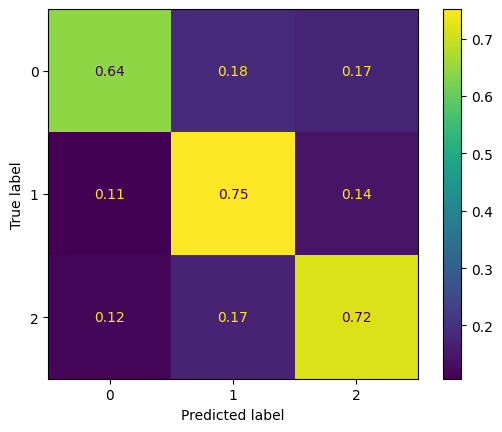

In [143]:
axial_lob_model.load_state_dict(torch.load(model_name, map_location=device))
axial_lob_model.to(device)
all_targets, all_predictions = test_model(axial_lob_model, criterion, test_loader)
print(classification_report(all_targets, all_predictions, digits=4))

c = confusion_matrix(all_targets, all_predictions, normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

# Model Comparisons
We will now test additional models to compare their performance against AxialLOB.

In [144]:
models_to_test: dict[str, nn.Module] = {}

In [149]:
class CNN(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.conv = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Linear(16, num_classes)

    def forward(self, x):
        x = torch.relu(self.conv(x))
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        return self.fc(x)

models_to_test["CNN"] = CNN(W, num_classes).to(device)

In [150]:
class DeepLOB(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.lstm = nn.LSTM(W * 128, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = torch.relu(self.bn1(self.conv1(x)))
        x = torch.relu(self.bn2(self.conv2(x)))
        x = torch.relu(self.bn3(self.conv3(x)))
        batch_size, channels, height, width = x.size()
        x = x.view(batch_size, height, -1)
        x, _ = self.lstm(x)
        x = x[:, -1, :]
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOB"] = DeepLOB(W, hidden_size, num_classes).to(device)

In [151]:
class B_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

class C_TABL(nn.Module):
    def __init__(self, W, num_classes):
        super().__init__()
        self.fc1 = nn.Linear(W * W, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten input
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        return self.fc3(x)

models_to_test["B_TABL"] = B_TABL(W, num_classes).to(device)
models_to_test["C_TABL"] = C_TABL(W, num_classes).to(device)

In [152]:
class DeepLOBSeq2Seq(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.decoder = nn.LSTM(2 * hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        # Reshape input
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1) 

        # Encoder
        encoder_output, (hidden, cell) = self.encoder(x)

        hidden = torch.cat((hidden[0:1], hidden[1:2]), dim=2)
        hidden = hidden.view(2, batch_size, self.hidden_size)

        cell = torch.cat((cell[0:1], cell[1:2]), dim=2)
        cell = cell.view(2, batch_size, self.hidden_size)

        # Decoder
        decoder_output, _ = self.decoder(encoder_output, (hidden, cell))

        # Use the last time step from the decoder
        x = decoder_output[:, -1, :]

        # Fully connected layer
        return self.fc(x)


hidden_size = 64
models_to_test["DeepLOBSeq2Seq"] = DeepLOBSeq2Seq(W, hidden_size, num_classes).to(device)


In [153]:
class DeepLOBAttention(nn.Module):
    def __init__(self, W, hidden_size, num_classes):
        super().__init__()
        self.encoder = nn.LSTM(W, hidden_size, batch_first=True, bidirectional=True)
        self.attention = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.Tanh(),
            nn.Linear(128, 1),
            nn.Softmax(dim=1)
        )
        self.fc = nn.Sequential(
            nn.Linear(2 * hidden_size, 128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        batch_size, _, height, _ = x.size()
        x = x.view(batch_size, height, -1)  # Flatten spatial dimensions
        x, _ = self.encoder(x)  # Encoder outputs
        attention_weights = self.attention(x)  # Compute attention weights
        x = torch.sum(attention_weights * x, dim=1)  # Apply attention
        return self.fc(x)

hidden_size = 64
models_to_test["DeepLOBAttention"] = DeepLOBAttention(W, hidden_size, num_classes).to(device)

In [155]:
# Load all models
def load_from_saved(models_to_test: dict[str, nn.Module], pretrained_loc: str | None = None):
# Load the models that were pretrained on the FI-2010 dataset
    all_loaded_successfully = True
    for model_name in models_to_test.keys():
        _save_path = Path(f"{pretrained_loc}/{model_name}.pt")
        if _save_path.exists():
            models_to_test[model_name].load_state_dict(torch.load(_save_path, map_location=device))
            models_to_test[model_name].to(device)
        else:
            print("WARNING: Tried to load from pretrained but did not find any saved models")
            all_loaded_successfully = False
    if all_loaded_successfully:
        print("All models loaded successfully")
    else:
        print("\nWARNING: At least one model was not loaded successfully. Please read the warning(s) above.\n")

load_from_saved(models_to_test, "all_models")

All models loaded successfully


C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\438007077.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_to_test[model_name].load_state_dict(torch.load(_save_p

Evaluating CNN on test set

Test acc: 0.5018. Test Loss: 1.0047. Time on test: 0:00:03.224519
              precision    recall  f1-score   support

           0     0.3190    0.0121    0.0234     38447
           1     0.5690    0.8259    0.6738     65996
           2     0.3559    0.4289    0.3890     35100

    accuracy                         0.5018    139543
   macro avg     0.4146    0.4223    0.3621    139543
weighted avg     0.4465    0.5018    0.4230    139543



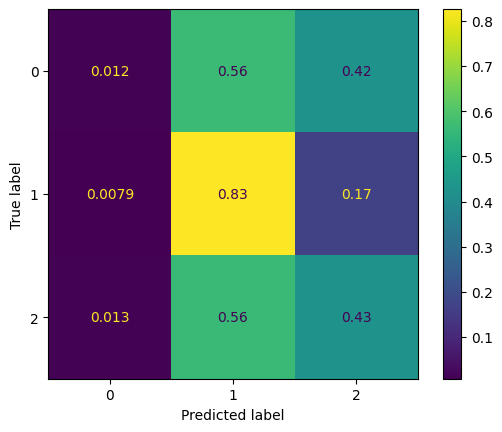



_________________________________


Evaluating DeepLOB on test set

Test acc: 0.7156. Test Loss: 0.7222. Time on test: 0:00:08.455506
              precision    recall  f1-score   support

           0     0.7398    0.5804    0.6504     38447
           1     0.7187    0.8478    0.7779     65996
           2     0.6848    0.6151    0.6481     35100

    accuracy                         0.7156    139543
   macro avg     0.7144    0.6811    0.6922    139543
weighted avg     0.7160    0.7156    0.7101    139543



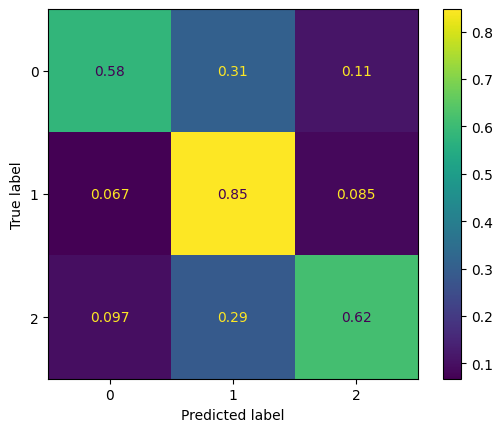



_________________________________


Evaluating B_TABL on test set

Test acc: 0.5995. Test Loss: 0.9399. Time on test: 0:00:02.781998
              precision    recall  f1-score   support

           0     0.5544    0.5066    0.5294     38447
           1     0.6507    0.6907    0.6701     65996
           2     0.5413    0.5298    0.5355     35100

    accuracy                         0.5995    139543
   macro avg     0.5821    0.5757    0.5784    139543
weighted avg     0.5967    0.5995    0.5975    139543



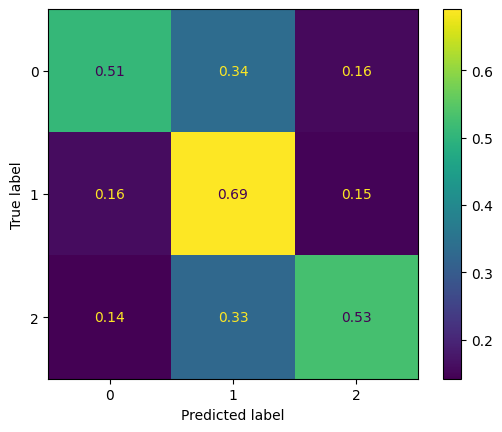



_________________________________


Evaluating C_TABL on test set

Test acc: 0.5166. Test Loss: 1.0276. Time on test: 0:00:03.101000
              precision    recall  f1-score   support

           0     0.4796    0.3675    0.4162     38447
           1     0.5675    0.6304    0.5973     65996
           2     0.4450    0.4660    0.4553     35100

    accuracy                         0.5166    139543
   macro avg     0.4973    0.4880    0.4896    139543
weighted avg     0.5124    0.5166    0.5117    139543



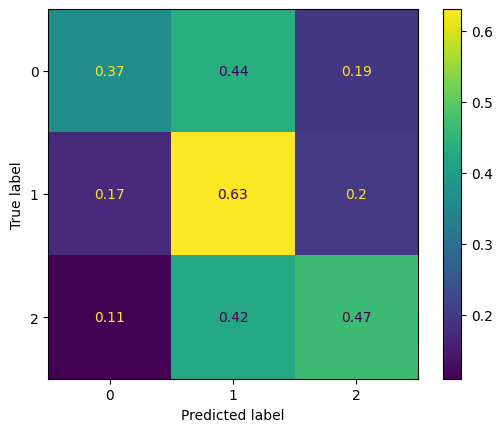



_________________________________


Evaluating DeepLOBSeq2Seq on test set

Test acc: 0.7163. Test Loss: 0.7140. Time on test: 0:00:04.347000
              precision    recall  f1-score   support

           0     0.6504    0.6839    0.6667     38447
           1     0.8016    0.7645    0.7826     65996
           2     0.6415    0.6610    0.6511     35100

    accuracy                         0.7163    139543
   macro avg     0.6978    0.7031    0.7001    139543
weighted avg     0.7196    0.7163    0.7176    139543



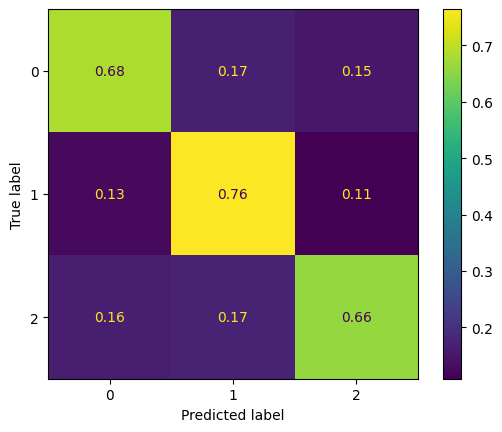



_________________________________


Evaluating DeepLOBAttention on test set

Test acc: 0.6976. Test Loss: 0.7533. Time on test: 0:00:04.148000
              precision    recall  f1-score   support

           0     0.6564    0.6083    0.6314     38447
           1     0.7739    0.7739    0.7739     65996
           2     0.6036    0.6520    0.6269     35100

    accuracy                         0.6976    139543
   macro avg     0.6780    0.6781    0.6774    139543
weighted avg     0.6987    0.6976    0.6977    139543



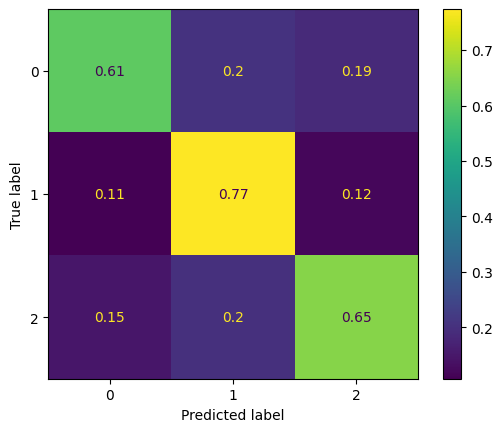



_________________________________




In [158]:
class FakeScheduler():
    "Class so we can call batch_gd with no scheduler"
    def step(self):
        pass

def evaluate_all(models: dict[str, nn.Module],
    epochs_per_model: int,
    train_loader: data.DataLoader,
    val_loader: data.DataLoader,
    test_loader: data.DataLoader,
    train_model: bool = False,
    save_dir: str = "all_models"
):
    """
    Trains each model (in place) in models on the dataset.
    """
    save_dir_path = Path(save_dir)
    save_dir_path.mkdir(parents=True, exist_ok=True)

    for model_name, model in models.items():

        criterion = nn.CrossEntropyLoss()

        if train_model:
            # Train the model and save it
            print(f"Training {model_name}...")
            model.to(device)
            optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
            scheduler = FakeScheduler()

            save_path = save_dir_path / f"{model_name}.pt"
            batch_gd(model, criterion, optimizer, scheduler, epochs_per_model, save_path, train_loader, val_loader, force_save=True)

            # Load the new best model
            
            model.load_state_dict(torch.load(save_path, map_location=device))
            model.to(device)

        # Evaluate the model
        # Load the best saved model
        print(f"Evaluating {model_name} on test set\n")
        all_targets, all_predictions = test_model(model, criterion, test_loader)

        print(classification_report(all_targets, all_predictions, digits=4))

        c = confusion_matrix(all_targets, all_predictions, normalize="true")
        disp = ConfusionMatrixDisplay(c)
        disp.plot()
        plt.show()

        # Replace old model with new model
        models[model_name] = model
        print("\n\n_________________________________\n\n")

evaluate_all(models_to_test, epochs, train_loader, val_loader, test_loader, train_model=TRAIN_MODELS)

# Run a Market Simulation with AxialLOB

In [159]:
class BuySellDataset(data.Dataset):
    """
    Dataset to handle buying and selling simulation
    """
    def __init__(self, x, num_classes, dim, rescale_prices: bool = True):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x
        self.prices = self.compute_mid_prices(x, rescale_prices)

        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.prices = torch.from_numpy(self.prices)

    def compute_mid_prices(self, x, rescale_prices: bool = True):
        """
        Compute the mid-price as the average of ask and bid prices.
        Assuming ask and bid prices are alternating in the columns.
        """
        mid_prices = []
        for i in range(x.shape[0]):
            ask_prices = x[i, 0]  # Assuming best ask is at column 1
            bid_prices = x[i, 20]  # Assuming best bid is at column 21
            mid_price = (ask_prices + bid_prices) / 2  # Calculate mid-price
            mid_prices.append(mid_price)
        mid_prices = np.array(mid_prices)
        if rescale_prices:
            mid_prices = mid_prices - np.min(mid_prices) + 0.5 # ensure price >=0.5 so no negative or 0 prices
        return mid_prices

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):
        input = self.x[i:i+self.dim, :]
        input = input.permute(1, 0, 2)
        
        return input, self.prices[i]

buy_sell_dataset_test = BuySellDataset(dec_test, num_classes, dim, rescale_prices=True)
buy_sell_test_loader = torch.utils.data.DataLoader(dataset=buy_sell_dataset_test, batch_size=batch_size, shuffle=False)


# Trading Strategy Simulation
def simulate_trading_debug(preds, prices, initial_cash=10000, transaction_cost=0.001):
    cash = initial_cash
    stock = 0
    print(f"Initial cash: {cash}, transaction cost: {transaction_cost}")

    portfolio_value = initial_cash
    final_price = prices[-1]

    for i, (pred, price) in enumerate(zip(preds, prices)):
        if pred == 2 and cash != 0:  # Buy signal
            num_shares = cash / (price * (1 + transaction_cost))
            cash -= num_shares * price * (1 + transaction_cost)
            stock += num_shares
            print(f"BUY at step {i}: Bought {num_shares:.2f} shares at {price:.2f}, Cash: {cash:.2f}, Stock: {stock:.2f}")
        elif pred == 0 and stock != 0:  # Sell signal
            cash += stock * price * (1 - transaction_cost)
            print(f"SELL at step {i}: Sold {stock:.2f} shares at {price:.2f}, Cash: {cash:.2f}")
            stock = 0
        
        portfolio_value = cash + stock * price
        if portfolio_value <= 0.001:
            final_price = price
            print("Ending simulation early. Model ran out of assets")
            break

        # Hold signal does nothing

    print(f"Final Portfolio Value: {portfolio_value:.2f}, Remaining Cash: {cash:.2f}, Remaining Stock at price {final_price:.2f}: {stock:.2f}. Initial price was {prices[0]}")
    print(f"Amount earned: {portfolio_value - initial_cash}")
    return portfolio_value

# Evaluation with Debugging
def evaluate_strategy_debug(model: nn.Module):
    """
    Given a trained model, test how well it does at trading
    """
    model.eval()
    all_preds = []
    prices_test = []
    with torch.no_grad():
        for inputs, prices in buy_sell_test_loader:
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
            prices_test.append(prices.cpu().numpy())


    preds = np.concatenate(all_preds)
    prices_test = np.concatenate(prices_test)
    if len(preds) >= 10:
        print(f"Predictions: {preds[:10]} ... {preds[-10:]} (first 10 and last 10 predictions)")
    return simulate_trading_debug(preds, prices_test)


In [160]:
evaluate_strategy_debug(axial_lob_model)

Predictions: [2 2 2 2 0 2 2 2 2 0] ... [1 1 1 1 1 1 1 1 1 1] (first 10 and last 10 predictions)
Initial cash: 10000, transaction cost: 0.001
BUY at step 0: Bought 5197.97 shares at 1.92, Cash: -0.00, Stock: 5197.97
BUY at step 1: Bought -0.00 shares at 1.93, Cash: 0.00, Stock: 5197.97
SELL at step 4: Sold 5197.97 shares at 1.92, Cash: 9977.43
BUY at step 5: Bought 5167.45 shares at 1.93, Cash: 0.00, Stock: 5167.45
SELL at step 9: Sold 5167.45 shares at 1.92, Cash: 9934.31
BUY at step 10: Bought 5161.14 shares at 1.92, Cash: 0.00, Stock: 5161.14
SELL at step 15: Sold 5161.14 shares at 1.92, Cash: 9919.61
BUY at step 16: Bought 5136.18 shares at 1.93, Cash: 0.00, Stock: 5136.18
SELL at step 25: Sold 5136.18 shares at 1.92, Cash: 9846.00
BUY at step 31: Bought 5108.64 shares at 1.93, Cash: 0.00, Stock: 5108.64
SELL at step 32: Sold 5108.64 shares at 1.93, Cash: 9826.33
BUY at step 34: Bought 5102.40 shares at 1.92, Cash: 0.00, Stock: 5102.40
SELL at step 51: Sold 5102.40 shares at 1.93, C

0.0009999241342467263

# Test on AAPL Yahoo Finance Data

In [161]:
# Get all the models to train and test on the new dataset
def get_models_to_test(load_from_pretrained: bool, pretrained_loc: str | None = None) -> dict[str, nn.Module]:
    models_to_test: dict[str, nn.Module] = {}
    models_to_test["AxialLOB"] = AxialLOB(W, dim, c_in_axial, c_out_axial, c_final, n_heads, pool_kernel, pool_stride).to(device)
    models_to_test["DeepLOB"] = DeepLOB(W, hidden_size, num_classes).to(device)
    models_to_test["B_TABL"] = B_TABL(W, num_classes).to(device)
    models_to_test["C_TABL"] = C_TABL(W, num_classes).to(device)
    models_to_test["DeepLOBSeq2Seq"] = DeepLOBSeq2Seq(W, hidden_size, num_classes).to(device)
    models_to_test["DeepLOBAttention"] = DeepLOBAttention(W, hidden_size, num_classes).to(device)

    if load_from_pretrained:
        print("Attempting to load from pretrained...")
        load_from_saved(models_to_test, pretrained_loc)
    return models_to_test

In [162]:
import yfinance as yf
import pandas as pd

def fetch_stock_data(ticker: str, start_date: str | None, end_date: str | None, period: str | None, perform_normilzation: bool, get_short_data: bool) -> pd.DataFrame:
    """
    Fetch historical stock data and approximate order book features.
    The LOB data provided in the FI-2010 dataset is not directly avaliable.
    Args:
        ticker (str): Stock ticker symbol.
        start_date (Optional[str]): Start date (YYYY-MM-DD).
        end_date (Optional[str]): End date (YYYY-MM-DD).
    Returns:
        pd.DataFrame: Data with approximated order book features.
    """
    # Download OHLCV data
    if get_short_data:
        if period is None:
            raise ValueError("Period must be specified for short data")
        df = yf.download(ticker, period=period, interval="1m", progress=False)
        print(f"Loading 1 minute interval data over the last {period}...")
    else:
        if start_date is None or end_date is None:
            raise ValueError("Start and end date must be specified for longer data")
        print(f"Loading 1 day interval data over the period {start_date} to {end_date}")
        df = yf.download(ticker, start=start_date, end=end_date, progress=False)
    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    
    # Calculate mid-price and range
    df['Mid_Price'] = (df['High'] + df['Low']) / 2
    df['Range'] = df['High'] - df['Low']
    
    # Approximate ask/bid prices
    for i in range(10):
        weight = (i + 1) / 10
        df[f'Ask_Price_{i+1}'] = df['Mid_Price'] + weight * 0.5 * df['Range']
        df[f'Bid_Price_{i+1}'] = df['Mid_Price'] - weight * 0.5 * df['Range']
    
    # Approximate ask/bid volumes (split volume evenly as we lack granularity)
    total_volume = df['Volume']
    for i in range(10):
        df[f'Ask_Volume_{i+1}'] = total_volume / 20  # Split half for ask
        df[f'Bid_Volume_{i+1}'] = total_volume / 20  # Split half for bid
    
    # Drop unused columns
    df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Mid_Price', 'Range'], inplace=True)
    
    # Drop NaN rows
    df.dropna(inplace=True)

    if perform_normilzation:
        for column in df.columns:
            col_mean = df[column].mean()
            col_std = df[column].std()
            df[column] = (df[column] - col_mean) / col_std
    
    return df

def create_sequences(data, dim, horizon):
    """
    Create sequences for training/testing based on FI-2010 format.
    Args:
        data (np.ndarray): Input data (order book features).
        dim (int): Sequence length.
        horizon (int): Prediction horizon.
    Returns:
        tuple: Sequences (features), labels, and prices.
    """
    sequences, labels, prices = [], [], []
    N = data.shape[0]
    
    for i in range(N - dim - horizon + 1):
        seq = data[i:i + dim, :]  # Dimensional sequence (10 ask, 10 ask volume, etc.)
        # Use future mid-price to define labels
        future_mid_price = (data[i + dim + horizon - 1, 9] + data[i + dim + horizon - 1, 19]) / 2  # Ask10 + Bid10
        current_mid_price = (data[i + dim - 1, 9] + data[i + dim - 1, 19]) / 2  # Ask10 + Bid10
        price_change = (future_mid_price - current_mid_price) / current_mid_price
        
        # Label: 2 (Buy), 1 (Hold), 0 (Sell)
        label = 2 if price_change > 0.001 else (0 if price_change < -0.001 else 1)
        
        sequences.append(seq)
        labels.append(label)
        prices.append(future_mid_price)
    
    return np.array(sequences), np.array(labels, dtype=np.int64), np.array(prices)

class YahooDataset(data.Dataset):
    """Characterizes a dataset for PyTorch"""
    def __init__(self, x, y, num_classes, dim):
        """Initialization""" 
        self.num_classes = num_classes
        self.dim = dim
        self.x = x   
        self.y = y

        self.length = x.shape[0] - T - self.dim + 1

        x = torch.from_numpy(x)
        self.x = torch.unsqueeze(x, 1)
        self.y = torch.from_numpy(y)

    def __len__(self):
        """Denotes the total number of samples"""
        return self.length

    def __getitem__(self, i):        
        return self.x[i, :], self.y[i]

# Parameters
ticker = "AAPL"
start_date = "2021-01-01"
end_date = "2024-10-10"
period = "5d"

# Fetch and prepare data
# If we are using pretrained models on the FI-2010 dataset, we need to normalize the data
# The FI-2010 dataset has a Z-norm applied to it
stock_data = fetch_stock_data(ticker, start_date=start_date, end_date=end_date, period=None, perform_normilzation=False, get_short_data=False)
data_np_long = stock_data.to_numpy()
stock_data = fetch_stock_data(ticker, start_date=None, end_date=None, period=period, perform_normilzation=True, get_short_data=True)
data_np_short = stock_data.to_numpy()

# Create sequences
sequences_long, labels_long, prices_long = create_sequences(data_np_long, dim, horizon)
sequences_short, labels_short, prices_short = create_sequences(data_np_short, dim, horizon)
print(f"Shape of Yahoo Finance Data over 1 day intervals: {sequences_long.shape}")
print(f"Shape of Yahoo Finance Data over 1 minute intervals: {sequences_short.shape}")

Loading 1 day interval data over the period 2021-01-01 to 2024-10-10


C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\1115154613.py:45: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Mid_Price', 'Range'], inplace=True)


Loading 1 minute interval data over the last 5d...
Shape of Yahoo Finance Data over 1 day intervals: (907, 40, 40)
Shape of Yahoo Finance Data over 1 minute intervals: (1905, 40, 40)


C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\1115154613.py:45: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  df.drop(columns=['Open', 'High', 'Low', 'Close', 'Volume', 'Mid_Price', 'Range'], inplace=True)


In [163]:
def get_data(X, y, prices) -> tuple[data.DataLoader, data.DataLoader, data.DataLoader, np.ndarray]:
    # Split the data into training, validation, and testing sets
    # Perform train-test 80/20 split
    train_size = int(0.8 * len(X))
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    prices_test = prices[train_size:]

    # Split the training data into 90 train, 10 val
    train_size = int(0.9 * len(X_train))
    X_train, X_val = X_train[:train_size], X_train[train_size:]
    y_train, y_val = y_train[:train_size], y_train[train_size:]

    # Reuse DataLoader setup
    train_loader = data.DataLoader(
        YahooDataset(X_train, y_train, num_classes, dim), batch_size=batch_size, shuffle=True
    )
    test_loader = data.DataLoader(
        YahooDataset(X_test, y_test, num_classes, dim), batch_size=batch_size, shuffle=False
    )
    val_loader = data.DataLoader(
        YahooDataset(X_val, y_val, num_classes, dim), batch_size=batch_size, shuffle=False
    )

    inputs, labels = next(iter(train_loader))
    print("Input batch shape:", inputs.shape)
    print("Label batch shape:", labels.shape)
    return train_loader, val_loader, test_loader, prices_test

In [ ]:
save_loc = "AAPL"
epochs = 20
TRAIN_APPL = True

Evaluating models from scratch on 1 day interval APPL data from 2021-01-01 to 2024-10-10
Input batch shape: torch.Size([64, 1, 40, 40])
Label batch shape: torch.Size([64])
Training AxialLOB...


  5%|▌         | 1/20 [00:01<00:21,  1.13s/it]

model saved at APPL_long\AxialLOB.pt
Epoch 1/20, Train Loss: 0.9974,           Validation Loss: 0.9838, Duration: 0:00:01.130509, Best Val Epoch: 0


 10%|█         | 2/20 [00:01<00:17,  1.02it/s]

Epoch 2/20, Train Loss: 0.9506,           Validation Loss: 0.9864, Duration: 0:00:00.868999, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:02<00:15,  1.07it/s]

model saved at APPL_long\AxialLOB.pt
Epoch 3/20, Train Loss: 0.9268,           Validation Loss: 0.9692, Duration: 0:00:00.877999, Best Val Epoch: 2


 20%|██        | 4/20 [00:03<00:14,  1.10it/s]

Epoch 4/20, Train Loss: 0.9036,           Validation Loss: 0.9731, Duration: 0:00:00.865999, Best Val Epoch: 2
Turning on additional grads for AxialLOB...


 25%|██▌       | 5/20 [00:04<00:13,  1.10it/s]

Epoch 5/20, Train Loss: 0.8755,           Validation Loss: 0.9804, Duration: 0:00:00.903999, Best Val Epoch: 2


 30%|███       | 6/20 [00:05<00:12,  1.10it/s]

Epoch 6/20, Train Loss: 0.8376,           Validation Loss: 0.9726, Duration: 0:00:00.903000, Best Val Epoch: 2


 35%|███▌      | 7/20 [00:06<00:11,  1.10it/s]

Epoch 7/20, Train Loss: 0.8219,           Validation Loss: 1.0054, Duration: 0:00:00.904001, Best Val Epoch: 2


 40%|████      | 8/20 [00:07<00:10,  1.10it/s]

model saved at APPL_long\AxialLOB.pt
Epoch 8/20, Train Loss: 0.7991,           Validation Loss: 0.9235, Duration: 0:00:00.918997, Best Val Epoch: 7


 45%|████▌     | 9/20 [00:08<00:10,  1.10it/s]

Epoch 9/20, Train Loss: 0.7677,           Validation Loss: 0.9582, Duration: 0:00:00.906999, Best Val Epoch: 7


 50%|█████     | 10/20 [00:09<00:09,  1.10it/s]

model saved at APPL_long\AxialLOB.pt
Epoch 10/20, Train Loss: 0.7416,           Validation Loss: 0.8955, Duration: 0:00:00.917000, Best Val Epoch: 9


 55%|█████▌    | 11/20 [00:10<00:08,  1.09it/s]

model saved at APPL_long\AxialLOB.pt
Epoch 11/20, Train Loss: 0.7380,           Validation Loss: 0.8531, Duration: 0:00:00.921000, Best Val Epoch: 10


 60%|██████    | 12/20 [00:11<00:07,  1.10it/s]

Epoch 12/20, Train Loss: 0.7252,           Validation Loss: 0.9255, Duration: 0:00:00.909510, Best Val Epoch: 10


 65%|██████▌   | 13/20 [00:11<00:06,  1.10it/s]

Epoch 13/20, Train Loss: 0.6974,           Validation Loss: 0.9031, Duration: 0:00:00.908001, Best Val Epoch: 10


 70%|███████   | 14/20 [00:12<00:05,  1.10it/s]

Epoch 14/20, Train Loss: 0.6873,           Validation Loss: 0.8951, Duration: 0:00:00.907999, Best Val Epoch: 10


 75%|███████▌  | 15/20 [00:13<00:04,  1.10it/s]

Epoch 15/20, Train Loss: 0.6678,           Validation Loss: 0.9391, Duration: 0:00:00.906999, Best Val Epoch: 10


 80%|████████  | 16/20 [00:14<00:03,  1.10it/s]

Epoch 16/20, Train Loss: 0.6631,           Validation Loss: 0.9164, Duration: 0:00:00.907996, Best Val Epoch: 10


 85%|████████▌ | 17/20 [00:15<00:02,  1.10it/s]

Epoch 17/20, Train Loss: 0.6507,           Validation Loss: 0.9419, Duration: 0:00:00.909374, Best Val Epoch: 10


 90%|█████████ | 18/20 [00:16<00:01,  1.10it/s]

Epoch 18/20, Train Loss: 0.6505,           Validation Loss: 0.9181, Duration: 0:00:00.906997, Best Val Epoch: 10


 95%|█████████▌| 19/20 [00:17<00:00,  1.10it/s]

Epoch 19/20, Train Loss: 0.6370,           Validation Loss: 0.8738, Duration: 0:00:00.905998, Best Val Epoch: 10


100%|██████████| 20/20 [00:18<00:00,  1.09it/s]

Epoch 20/20, Train Loss: 0.6321,           Validation Loss: 0.8860, Duration: 0:00:00.906999, Best Val Epoch: 10
Full time to train: 0:00:18.304394. Average time per epoch: 0:00:00.915220
Evaluating AxialLOB on test set

Test acc: 0.5000. Test Loss: 1.0616. Time on test: 0:00:00.050999
              precision    recall  f1-score   support

           0     0.3333    0.0645    0.1081        62
           1     0.0000    0.0000    0.0000         4
           2     0.5159    0.9028    0.6566        72

    accuracy                         0.5000       138
   macro avg     0.2831    0.3224    0.2549       138
weighted avg     0.4189    0.5000    0.3911       138




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

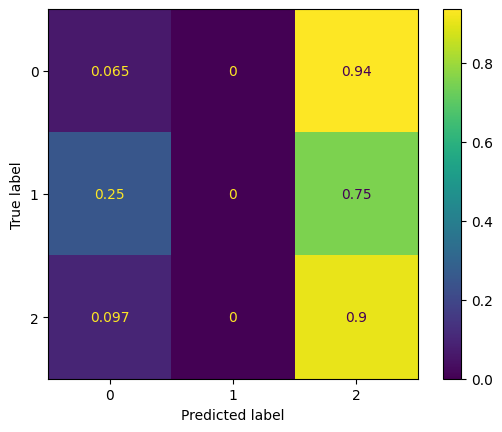



_________________________________


Training DeepLOB...


  5%|▌         | 1/20 [00:00<00:02,  8.70it/s]

model saved at APPL_long\DeepLOB.pt
Epoch 1/20, Train Loss: 0.9231,           Validation Loss: 0.6888, Duration: 0:00:00.114999, Best Val Epoch: 0


 10%|█         | 2/20 [00:00<00:01,  9.37it/s]

Epoch 2/20, Train Loss: 0.8643,           Validation Loss: 0.7256, Duration: 0:00:00.100001, Best Val Epoch: 0
Epoch 3/20, Train Loss: 0.8565,           Validation Loss: 0.6902, Duration: 0:00:00.101000, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:00<00:01,  9.60it/s]

Epoch 4/20, Train Loss: 0.8472,           Validation Loss: 0.7199, Duration: 0:00:00.099997, Best Val Epoch: 0

 25%|██▌       | 5/20 [00:00<00:01,  9.75it/s]


Epoch 5/20, Train Loss: 0.8604,           Validation Loss: 0.6998, Duration: 0:00:00.100996, Best Val Epoch: 0


 35%|███▌      | 7/20 [00:00<00:01,  9.49it/s]

Epoch 6/20, Train Loss: 0.8560,           Validation Loss: 0.7176, Duration: 0:00:00.098997, Best Val Epoch: 0
model saved at APPL_long\DeepLOB.pt
Epoch 7/20, Train Loss: 0.8552,           Validation Loss: 0.6780, Duration: 0:00:00.112000, Best Val Epoch: 6
Epoch 8/20, Train Loss: 0.8457,           Validation Loss: 0.7088, Duration: 0:00:00.100000, Best Val Epoch: 6


 50%|█████     | 10/20 [00:01<00:01,  9.77it/s]

Epoch 9/20, Train Loss: 0.8452,           Validation Loss: 0.6858, Duration: 0:00:00.101001, Best Val Epoch: 6
Epoch 10/20, Train Loss: 0.8402,           Validation Loss: 0.6849, Duration: 0:00:00.100000, Best Val Epoch: 6


 60%|██████    | 12/20 [00:01<00:00,  9.59it/s]

model saved at APPL_long\DeepLOB.pt
Epoch 11/20, Train Loss: 0.8419,           Validation Loss: 0.6735, Duration: 0:00:00.111000, Best Val Epoch: 10
Epoch 12/20, Train Loss: 0.8286,           Validation Loss: 0.7082, Duration: 0:00:00.100997, Best Val Epoch: 10
Epoch 13/20, Train Loss: 0.8061,           Validation Loss: 0.7127, Duration: 0:00:00.100999, Best Val Epoch: 10


 75%|███████▌  | 15/20 [00:01<00:00,  9.75it/s]

Epoch 14/20, Train Loss: 0.8034,           Validation Loss: 0.7213, Duration: 0:00:00.101001, Best Val Epoch: 10
Epoch 15/20, Train Loss: 0.7461,           Validation Loss: 0.7370, Duration: 0:00:00.100999, Best Val Epoch: 10
Epoch 16/20, Train Loss: 0.7328,           Validation Loss: 0.7539, Duration: 0:00:00.102000, Best Val Epoch: 10


 90%|█████████ | 18/20 [00:01<00:00,  9.81it/s]

Epoch 17/20, Train Loss: 0.7159,           Validation Loss: 0.9486, Duration: 0:00:00.102001, Best Val Epoch: 10
Epoch 18/20, Train Loss: 0.6383,           Validation Loss: 0.8477, Duration: 0:00:00.100000, Best Val Epoch: 10
Epoch 19/20, Train Loss: 0.5817,           Validation Loss: 0.9898, Duration: 0:00:00.101000, Best Val Epoch: 10


100%|██████████| 20/20 [00:02<00:00,  9.69it/s]

Epoch 20/20, Train Loss: 0.5239,           Validation Loss: 0.8161, Duration: 0:00:00.100000, Best Val Epoch: 10
Full time to train: 0:00:02.065999. Average time per epoch: 0:00:00.103300
Evaluating DeepLOB on test set

Test acc: 0.5290. Test Loss: 0.8689. Time on test: 0:00:00.007999
              precision    recall  f1-score   support

           0     1.0000    0.0161    0.0317        62
           1     0.0000    0.0000    0.0000         4
           2     0.5255    1.0000    0.6890        72

    accuracy                         0.5290       138
   macro avg     0.5085    0.3387    0.2402       138
weighted avg     0.7235    0.5290    0.3737       138




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

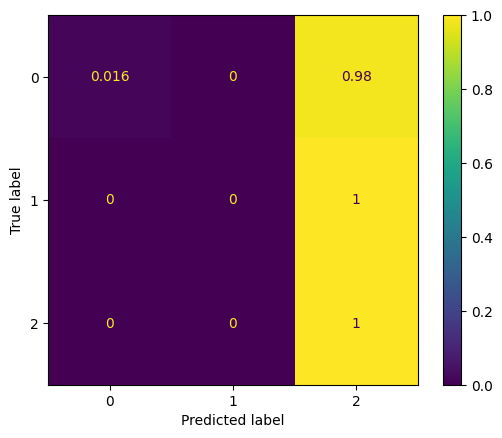



_________________________________


Training B_TABL...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_long\B_TABL.pt
Epoch 1/20, Train Loss: 1271557.1609,           Validation Loss: 180168.9062, Duration: 0:00:00.021998, Best Val Epoch: 0
model saved at APPL_long\B_TABL.pt
Epoch 2/20, Train Loss: 272201.1016,           Validation Loss: 32425.3477, Duration: 0:00:00.027001, Best Val Epoch: 1
Epoch 3/20, Train Loss: 216155.3758,           Validation Loss: 40117.8633, Duration: 0:00:00.023001, Best Val Epoch: 1
Epoch 4/20, Train Loss: 152359.9680,           Validation Loss: 57602.7070, Duration: 0:00:00.016998, Best Val Epoch: 1


 25%|██▌       | 5/20 [00:00<00:00, 47.17it/s]

Epoch 5/20, Train Loss: 85899.9246,           Validation Loss: 53536.0547, Duration: 0:00:00.016001, Best Val Epoch: 1
model saved at APPL_long\B_TABL.pt
Epoch 6/20, Train Loss: 59855.1680,           Validation Loss: 13046.7129, Duration: 0:00:00.018998, Best Val Epoch: 5
model saved at APPL_long\B_TABL.pt
Epoch 7/20, Train Loss: 35579.9489,           Validation Loss: 12179.9521, Duration: 0:00:00.021001, Best Val Epoch: 6
model saved at APPL_long\B_TABL.pt
Epoch 8/20, Train Loss: 21103.4128,           Validation Loss: 11314.2021, Duration: 0:00:00.017999, Best Val Epoch: 7
Epoch 9/20, Train Loss: 18849.8347,           Validation Loss: 15978.0732, Duration: 0:00:00.017000, Best Val Epoch: 7
model saved at APPL_long\B_TABL.pt
Epoch 10/20, Train Loss: 19293.3765,           Validation Loss: 10612.6055, Duration: 0:00:00.020000, Best Val Epoch: 9


 55%|█████▌    | 11/20 [00:00<00:00, 50.21it/s]

model saved at APPL_long\B_TABL.pt
Epoch 11/20, Train Loss: 15642.6544,           Validation Loss: 9466.3301, Duration: 0:00:00.020000, Best Val Epoch: 10
model saved at APPL_long\B_TABL.pt
Epoch 12/20, Train Loss: 30690.7900,           Validation Loss: 6820.0386, Duration: 0:00:00.022000, Best Val Epoch: 11
Epoch 13/20, Train Loss: 27652.5277,           Validation Loss: 19680.3262, Duration: 0:00:00.017000, Best Val Epoch: 11
model saved at APPL_long\B_TABL.pt
Epoch 14/20, Train Loss: 28326.1183,           Validation Loss: 3960.6638, Duration: 0:00:00.019001, Best Val Epoch: 13
Epoch 15/20, Train Loss: 25262.4808,           Validation Loss: 13036.4980, Duration: 0:00:00.019000, Best Val Epoch: 13


100%|██████████| 20/20 [00:00<00:00, 51.02it/s]

Epoch 16/20, Train Loss: 35877.1607,           Validation Loss: 4230.7261, Duration: 0:00:00.019999, Best Val Epoch: 13
Epoch 17/20, Train Loss: 39107.0215,           Validation Loss: 5478.6680, Duration: 0:00:00.018002, Best Val Epoch: 13
Epoch 18/20, Train Loss: 21620.3074,           Validation Loss: 16236.4268, Duration: 0:00:00.019000, Best Val Epoch: 13
Epoch 19/20, Train Loss: 27373.7725,           Validation Loss: 6429.9028, Duration: 0:00:00.019999, Best Val Epoch: 13
Epoch 20/20, Train Loss: 27233.3571,           Validation Loss: 16724.4375, Duration: 0:00:00.016000, Best Val Epoch: 13
Full time to train: 0:00:00.394000. Average time per epoch: 0:00:00.019700
Evaluating B_TABL on test set

Test acc: 0.4493. Test Loss: 29170.8509. Time on test: 0:00:00.001999
              precision    recall  f1-score   support

           0     0.3684    0.2258    0.2800        62
           1     0.0000    0.0000    0.0000         4
           2     0.4898    0.6667    0.5647        72

    


C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

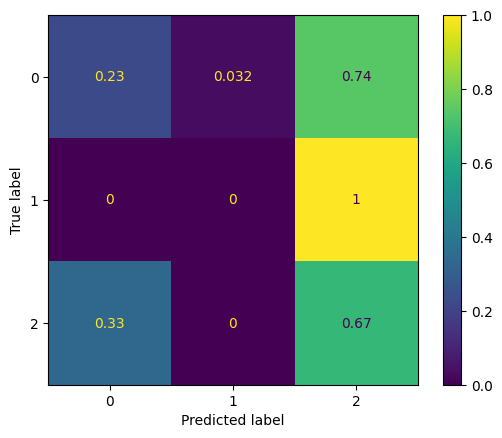



_________________________________


Training C_TABL...


 25%|██▌       | 5/20 [00:00<00:00, 46.30it/s]

model saved at APPL_long\C_TABL.pt
Epoch 1/20, Train Loss: 622055.3344,           Validation Loss: 54832.7383, Duration: 0:00:00.021999, Best Val Epoch: 0
Epoch 2/20, Train Loss: 185903.0451,           Validation Loss: 167757.7188, Duration: 0:00:00.020998, Best Val Epoch: 0
Epoch 3/20, Train Loss: 166549.9197,           Validation Loss: 141097.7344, Duration: 0:00:00.022001, Best Val Epoch: 0
model saved at APPL_long\C_TABL.pt
Epoch 4/20, Train Loss: 163087.0297,           Validation Loss: 7845.5166, Duration: 0:00:00.024000, Best Val Epoch: 3
Epoch 5/20, Train Loss: 72051.0463,           Validation Loss: 39469.3164, Duration: 0:00:00.018999, Best Val Epoch: 3
Epoch 6/20, Train Loss: 53444.4625,           Validation Loss: 54152.9883, Duration: 0:00:00.019001, Best Val Epoch: 3
Epoch 7/20, Train Loss: 57533.3345,           Validation Loss: 31464.9336, Duration: 0:00:00.017999, Best Val Epoch: 3
Epoch 8/20, Train Loss: 60941.1012,           Validation Loss: 14633.6289, Duration: 0:00:00

 80%|████████  | 16/20 [00:00<00:00, 47.63it/s]


Epoch 11/20, Train Loss: 24978.7020,           Validation Loss: 32698.1953, Duration: 0:00:00.023000, Best Val Epoch: 8
Epoch 12/20, Train Loss: 34100.8108,           Validation Loss: 9652.2852, Duration: 0:00:00.020999, Best Val Epoch: 8
Epoch 13/20, Train Loss: 21783.6362,           Validation Loss: 16799.7344, Duration: 0:00:00.021001, Best Val Epoch: 8
Epoch 14/20, Train Loss: 9189.9433,           Validation Loss: 12230.1211, Duration: 0:00:00.019999, Best Val Epoch: 8
Epoch 15/20, Train Loss: 10964.1611,           Validation Loss: 5526.0215, Duration: 0:00:00.020000, Best Val Epoch: 8
model saved at APPL_long\C_TABL.pt
Epoch 16/20, Train Loss: 8129.4810,           Validation Loss: 2531.4236, Duration: 0:00:00.024001, Best Val Epoch: 15
model saved at APPL_long\C_TABL.pt
Epoch 17/20, Train Loss: 4717.1405,           Validation Loss: 2069.9568, Duration: 0:00:00.023998, Best Val Epoch: 16
model saved at APPL_long\C_TABL.pt
Epoch 18/20, Train Loss: 3980.6877,           Validation Lo

100%|██████████| 20/20 [00:00<00:00, 47.62it/s]

Full time to train: 0:00:00.422004. Average time per epoch: 0:00:00.021100
Evaluating C_TABL on test set

Test acc: 0.3768. Test Loss: 6914.1140. Time on test: 0:00:00.003001
              precision    recall  f1-score   support

           0     0.3103    0.1452    0.1978        62
           1     0.0000    0.0000    0.0000         4
           2     0.4526    0.5972    0.5150        72

    accuracy                         0.3768       138
   macro avg     0.2543    0.2475    0.2376       138
weighted avg     0.3756    0.3768    0.3575       138




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

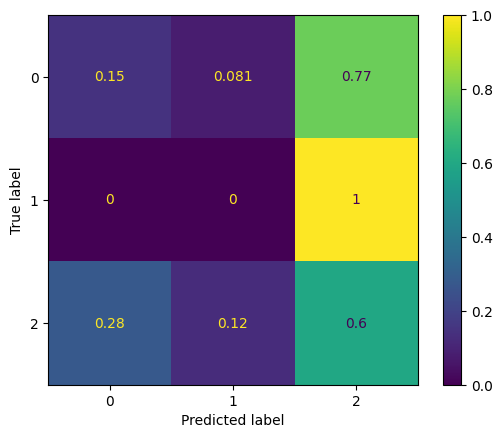



_________________________________


Training DeepLOBSeq2Seq...


 10%|█         | 2/20 [00:00<00:00, 19.42it/s]

model saved at APPL_long\DeepLOBSeq2Seq.pt
Epoch 1/20, Train Loss: 0.9855,           Validation Loss: 0.7453, Duration: 0:00:00.053000, Best Val Epoch: 0
model saved at APPL_long\DeepLOBSeq2Seq.pt
Epoch 2/20, Train Loss: 0.8720,           Validation Loss: 0.6869, Duration: 0:00:00.050000, Best Val Epoch: 1
Epoch 3/20, Train Loss: 0.8506,           Validation Loss: 0.6973, Duration: 0:00:00.050001, Best Val Epoch: 1
Epoch 4/20, Train Loss: 0.8545,           Validation Loss: 0.7103, Duration: 0:00:00.048002, Best Val Epoch: 1
Epoch 5/20, Train Loss: 0.8451,           Validation Loss: 0.7146, Duration: 0:00:00.052000, Best Val Epoch: 1

 25%|██▌       | 5/20 [00:00<00:00, 19.72it/s]


Epoch 6/20, Train Loss: 0.8551,           Validation Loss: 0.7194, Duration: 0:00:00.049996, Best Val Epoch: 1
Epoch 7/20, Train Loss: 0.8703,           Validation Loss: 0.6870, Duration: 0:00:00.049000, Best Val Epoch: 1


 40%|████      | 8/20 [00:00<00:00, 19.99it/s]

Epoch 8/20, Train Loss: 0.8505,           Validation Loss: 0.7417, Duration: 0:00:00.049002, Best Val Epoch: 1
Epoch 9/20, Train Loss: 0.8616,           Validation Loss: 0.7129, Duration: 0:00:00.049999, Best Val Epoch: 1


 55%|█████▌    | 11/20 [00:00<00:00, 20.68it/s]

Epoch 10/20, Train Loss: 0.8546,           Validation Loss: 0.7046, Duration: 0:00:00.042999, Best Val Epoch: 1
Epoch 11/20, Train Loss: 0.8736,           Validation Loss: 0.6962, Duration: 0:00:00.045001, Best Val Epoch: 1
Epoch 12/20, Train Loss: 0.8494,           Validation Loss: 0.7130, Duration: 0:00:00.047000, Best Val Epoch: 1
Epoch 13/20, Train Loss: 0.8500,           Validation Loss: 0.7120, Duration: 0:00:00.047000, Best Val Epoch: 1
Epoch 14/20, Train Loss: 0.8605,           Validation Loss: 0.6977, Duration: 0:00:00.048999, Best Val Epoch: 1


 70%|███████   | 14/20 [00:00<00:00, 20.68it/s]

Epoch 15/20, Train Loss: 0.8487,           Validation Loss: 0.6970, Duration: 0:00:00.041001, Best Val Epoch: 1
Epoch 16/20, Train Loss: 0.8567,           Validation Loss: 0.7031, Duration: 0:00:00.044002, Best Val Epoch: 1
Epoch 17/20, Train Loss: 0.8532,           Validation Loss: 0.7058, Duration: 0:00:00.042999, Best Val Epoch: 1


 85%|████████▌ | 17/20 [00:00<00:00, 21.40it/s]

Epoch 18/20, Train Loss: 0.8532,           Validation Loss: 0.7035, Duration: 0:00:00.043998, Best Val Epoch: 1
Epoch 19/20, Train Loss: 0.8433,           Validation Loss: 0.7014, Duration: 0:00:00.042000, Best Val Epoch: 1


100%|██████████| 20/20 [00:00<00:00, 21.16it/s]
C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_

Epoch 20/20, Train Loss: 0.8545,           Validation Loss: 0.7052, Duration: 0:00:00.042001, Best Val Epoch: 1
Full time to train: 0:00:00.947001. Average time per epoch: 0:00:00.047350
Evaluating DeepLOBSeq2Seq on test set

Test acc: 0.5217. Test Loss: 0.8630. Time on test: 0:00:00.003999
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        62
           1     0.0000    0.0000    0.0000         4
           2     0.5217    1.0000    0.6857        72

    accuracy                         0.5217       138
   macro avg     0.1739    0.3333    0.2286       138
weighted avg     0.2722    0.5217    0.3578       138



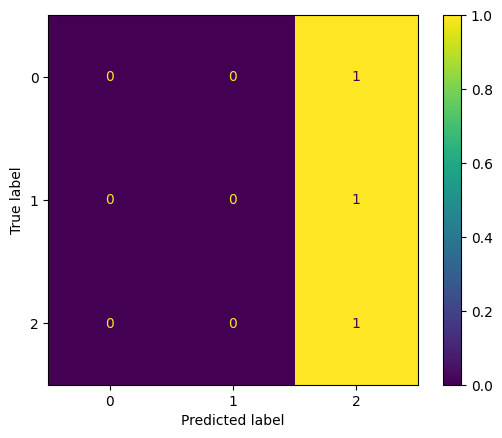



_________________________________


Training DeepLOBAttention...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_long\DeepLOBAttention.pt
Epoch 1/20, Train Loss: 0.9796,           Validation Loss: 0.7918, Duration: 0:00:00.043000, Best Val Epoch: 0
model saved at APPL_long\DeepLOBAttention.pt
Epoch 2/20, Train Loss: 0.8824,           Validation Loss: 0.7083, Duration: 0:00:00.039998, Best Val Epoch: 1


 15%|█▌        | 3/20 [00:00<00:00, 25.00it/s]

model saved at APPL_long\DeepLOBAttention.pt
Epoch 3/20, Train Loss: 0.8551,           Validation Loss: 0.7065, Duration: 0:00:00.037001, Best Val Epoch: 2
Epoch 4/20, Train Loss: 0.8475,           Validation Loss: 0.7075, Duration: 0:00:00.037999, Best Val Epoch: 2
model saved at APPL_long\DeepLOBAttention.pt
Epoch 5/20, Train Loss: 0.8561,           Validation Loss: 0.6818, Duration: 0:00:00.038001, Best Val Epoch: 4
Epoch 6/20, Train Loss: 0.8532,           Validation Loss: 0.7027, Duration: 0:00:00.039000, Best Val Epoch: 4

 30%|███       | 6/20 [00:00<00:00, 25.37it/s]


Epoch 7/20, Train Loss: 0.8480,           Validation Loss: 0.7111, Duration: 0:00:00.035998, Best Val Epoch: 4
Epoch 8/20, Train Loss: 0.8503,           Validation Loss: 0.6990, Duration: 0:00:00.035001, Best Val Epoch: 4


 45%|████▌     | 9/20 [00:00<00:00, 26.63it/s]

Epoch 9/20, Train Loss: 0.8479,           Validation Loss: 0.7003, Duration: 0:00:00.033999, Best Val Epoch: 4
Epoch 10/20, Train Loss: 0.8602,           Validation Loss: 0.7004, Duration: 0:00:00.037001, Best Val Epoch: 4
Epoch 11/20, Train Loss: 0.8514,           Validation Loss: 0.7059, Duration: 0:00:00.036001, Best Val Epoch: 4


 60%|██████    | 12/20 [00:00<00:00, 26.98it/s]

Epoch 12/20, Train Loss: 0.8532,           Validation Loss: 0.7149, Duration: 0:00:00.035998, Best Val Epoch: 4
Epoch 13/20, Train Loss: 0.8585,           Validation Loss: 0.7059, Duration: 0:00:00.038000, Best Val Epoch: 4
Epoch 14/20, Train Loss: 0.8598,           Validation Loss: 0.7093, Duration: 0:00:00.037001, Best Val Epoch: 4


 75%|███████▌  | 15/20 [00:00<00:00, 27.17it/s]

Epoch 15/20, Train Loss: 0.8432,           Validation Loss: 0.6977, Duration: 0:00:00.033002, Best Val Epoch: 4
Epoch 16/20, Train Loss: 0.8546,           Validation Loss: 0.6896, Duration: 0:00:00.036998, Best Val Epoch: 4
Epoch 17/20, Train Loss: 0.8526,           Validation Loss: 0.6941, Duration: 0:00:00.038001, Best Val Epoch: 4


 90%|█████████ | 18/20 [00:00<00:00, 27.04it/s]

Epoch 18/20, Train Loss: 0.8538,           Validation Loss: 0.7147, Duration: 0:00:00.035998, Best Val Epoch: 4
Epoch 19/20, Train Loss: 0.8534,           Validation Loss: 0.7027, Duration: 0:00:00.038998, Best Val Epoch: 4
Epoch 20/20, Train Loss: 0.8586,           Validation Loss: 0.7002, Duration: 0:00:00.036997, Best Val Epoch: 4


100%|██████████| 20/20 [00:00<00:00, 26.67it/s]

Full time to train: 0:00:00.752003. Average time per epoch: 0:00:00.037600
Evaluating DeepLOBAttention on test set

Test acc: 0.5217. Test Loss: 0.8611. Time on test: 0:00:00.005999
              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000        62
           1     0.0000    0.0000    0.0000         4
           2     0.5217    1.0000    0.6857        72

    accuracy                         0.5217       138
   macro avg     0.1739    0.3333    0.2286       138
weighted avg     0.2722    0.5217    0.3578       138




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

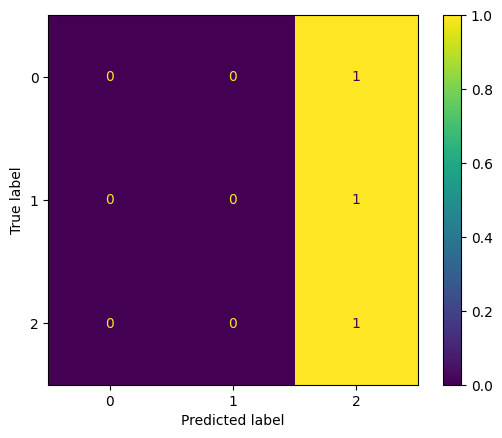



_________________________________




In [ ]:
# Train and evaluate models on long AAPL data
print(f"Evaluating models from scratch on 1 day interval AAPL data from {start_date} to {end_date}")
train_loader_long, val_loader_long, test_loader_long, prices_test_long = get_data(sequences_long, labels_long, prices_long)
evaluate_all(get_models_to_test(False, None), epochs, train_loader_long, val_loader_long, test_loader_long, train_model=TRAIN_APPL, save_dir=save_loc + "_long")

In [ ]:
# Train and evaluate models on short AAPL data
print(f"Evaluating models from scratch on 1 minute interval AAPL data over {period}")
train_loader_short, val_loader_short, test_loader_short, prices_test_short = get_data(sequences_short, labels_short, prices_short)

Evaluating models from scratch on 1 minute interval APPL data over 5d
Input batch shape: torch.Size([64, 1, 40, 40])
Label batch shape: torch.Size([64])


Train models from scratch on APPL data
Training AxialLOB...


  5%|▌         | 1/20 [00:02<00:40,  2.16s/it]

model saved at APPL_short(scratch)\AxialLOB.pt
Epoch 1/20, Train Loss: 0.9765,           Validation Loss: 0.9603, Duration: 0:00:02.157508, Best Val Epoch: 0


 10%|█         | 2/20 [00:04<00:36,  2.01s/it]

Epoch 2/20, Train Loss: 0.9409,           Validation Loss: 0.9653, Duration: 0:00:01.905000, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:05<00:33,  1.96s/it]

Epoch 3/20, Train Loss: 0.9312,           Validation Loss: 1.0012, Duration: 0:00:01.904000, Best Val Epoch: 0


 20%|██        | 4/20 [00:07<00:31,  1.94s/it]

Epoch 4/20, Train Loss: 0.9212,           Validation Loss: 0.9933, Duration: 0:00:01.916000, Best Val Epoch: 0
Turning on additional grads for AxialLOB...


 25%|██▌       | 5/20 [00:09<00:29,  1.96s/it]

Epoch 5/20, Train Loss: 0.9165,           Validation Loss: 1.0316, Duration: 0:00:01.996261, Best Val Epoch: 0


 30%|███       | 6/20 [00:11<00:27,  1.97s/it]

Epoch 6/20, Train Loss: 0.8926,           Validation Loss: 1.0165, Duration: 0:00:01.995000, Best Val Epoch: 0


 35%|███▌      | 7/20 [00:13<00:25,  1.98s/it]

Epoch 7/20, Train Loss: 0.8820,           Validation Loss: 1.0148, Duration: 0:00:01.991999, Best Val Epoch: 0


 40%|████      | 8/20 [00:15<00:23,  1.98s/it]

Epoch 8/20, Train Loss: 0.8828,           Validation Loss: 1.0103, Duration: 0:00:01.993001, Best Val Epoch: 0


 45%|████▌     | 9/20 [00:17<00:21,  1.99s/it]

Epoch 9/20, Train Loss: 0.8751,           Validation Loss: 1.0475, Duration: 0:00:01.994999, Best Val Epoch: 0


 50%|█████     | 10/20 [00:19<00:19,  1.99s/it]

Epoch 10/20, Train Loss: 0.8636,           Validation Loss: 1.0539, Duration: 0:00:01.999999, Best Val Epoch: 0


 55%|█████▌    | 11/20 [00:21<00:17,  1.99s/it]

Epoch 11/20, Train Loss: 0.8512,           Validation Loss: 1.0556, Duration: 0:00:01.992997, Best Val Epoch: 0


 60%|██████    | 12/20 [00:23<00:15,  1.99s/it]

Epoch 12/20, Train Loss: 0.8440,           Validation Loss: 1.0637, Duration: 0:00:01.992678, Best Val Epoch: 0


 65%|██████▌   | 13/20 [00:25<00:13,  1.99s/it]

Epoch 13/20, Train Loss: 0.8312,           Validation Loss: 1.0449, Duration: 0:00:01.994001, Best Val Epoch: 0


 70%|███████   | 14/20 [00:27<00:11,  2.00s/it]

Epoch 14/20, Train Loss: 0.8203,           Validation Loss: 1.0731, Duration: 0:00:01.998998, Best Val Epoch: 0


 75%|███████▌  | 15/20 [00:29<00:09,  2.00s/it]

Epoch 15/20, Train Loss: 0.8169,           Validation Loss: 1.0565, Duration: 0:00:01.998000, Best Val Epoch: 0


 80%|████████  | 16/20 [00:31<00:07,  2.00s/it]

Epoch 16/20, Train Loss: 0.8076,           Validation Loss: 1.0663, Duration: 0:00:02.001001, Best Val Epoch: 0


 85%|████████▌ | 17/20 [00:33<00:05,  2.00s/it]

Epoch 17/20, Train Loss: 0.7953,           Validation Loss: 1.0614, Duration: 0:00:01.998999, Best Val Epoch: 0


 90%|█████████ | 18/20 [00:35<00:03,  2.00s/it]

Epoch 18/20, Train Loss: 0.7903,           Validation Loss: 1.0707, Duration: 0:00:02.002000, Best Val Epoch: 0


 95%|█████████▌| 19/20 [00:37<00:02,  2.00s/it]

Epoch 19/20, Train Loss: 0.7969,           Validation Loss: 1.0733, Duration: 0:00:02.001996, Best Val Epoch: 0


100%|██████████| 20/20 [00:39<00:00,  1.99s/it]

Epoch 20/20, Train Loss: 0.7799,           Validation Loss: 1.0767, Duration: 0:00:02.000163, Best Val Epoch: 0
Full time to train: 0:00:39.855620. Average time per epoch: 0:00:01.992781
Evaluating AxialLOB on test set

Test acc: 0.4926. Test Loss: 0.9685. Time on test: 0:00:00.120000
              precision    recall  f1-score   support

           0     0.4167    0.0303    0.0565       165
           1     0.0000    0.0000    0.0000         4
           2     0.4954    0.9583    0.6531       168

    accuracy                         0.4926       337
   macro avg     0.3040    0.3295    0.2365       337
weighted avg     0.4510    0.4926    0.3533       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

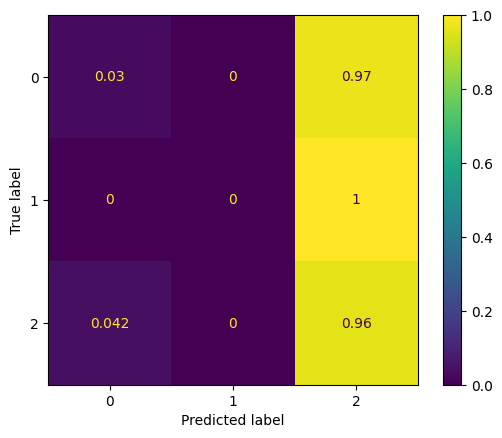



_________________________________


Training DeepLOB...


  5%|▌         | 1/20 [00:00<00:04,  4.29it/s]

model saved at APPL_short(scratch)\DeepLOB.pt
Epoch 1/20, Train Loss: 0.8190,           Validation Loss: 0.7701, Duration: 0:00:00.233000, Best Val Epoch: 0


 10%|█         | 2/20 [00:00<00:04,  4.28it/s]

model saved at APPL_short(scratch)\DeepLOB.pt
Epoch 2/20, Train Loss: 0.7429,           Validation Loss: 0.7446, Duration: 0:00:00.234000, Best Val Epoch: 1


 15%|█▌        | 3/20 [00:00<00:03,  4.40it/s]

Epoch 3/20, Train Loss: 0.7341,           Validation Loss: 0.7543, Duration: 0:00:00.219999, Best Val Epoch: 1


 20%|██        | 4/20 [00:00<00:03,  4.44it/s]

Epoch 4/20, Train Loss: 0.7315,           Validation Loss: 0.7690, Duration: 0:00:00.221000, Best Val Epoch: 1


 25%|██▌       | 5/20 [00:01<00:03,  4.48it/s]

Epoch 5/20, Train Loss: 0.7313,           Validation Loss: 0.7462, Duration: 0:00:00.220001, Best Val Epoch: 1


 30%|███       | 6/20 [00:01<00:03,  4.49it/s]

Epoch 6/20, Train Loss: 0.7278,           Validation Loss: 0.7616, Duration: 0:00:00.219998, Best Val Epoch: 1


 35%|███▌      | 7/20 [00:01<00:02,  4.50it/s]

Epoch 7/20, Train Loss: 0.7234,           Validation Loss: 0.7474, Duration: 0:00:00.219998, Best Val Epoch: 1


 40%|████      | 8/20 [00:01<00:02,  4.50it/s]

Epoch 8/20, Train Loss: 0.7122,           Validation Loss: 0.7595, Duration: 0:00:00.221998, Best Val Epoch: 1


 45%|████▌     | 9/20 [00:02<00:02,  4.51it/s]

Epoch 9/20, Train Loss: 0.7052,           Validation Loss: 0.7645, Duration: 0:00:00.219998, Best Val Epoch: 1


 50%|█████     | 10/20 [00:02<00:02,  4.50it/s]

Epoch 10/20, Train Loss: 0.7015,           Validation Loss: 0.7911, Duration: 0:00:00.220999, Best Val Epoch: 1


 55%|█████▌    | 11/20 [00:02<00:02,  4.50it/s]

Epoch 11/20, Train Loss: 0.6709,           Validation Loss: 0.8030, Duration: 0:00:00.222001, Best Val Epoch: 1


 60%|██████    | 12/20 [00:02<00:01,  4.52it/s]

Epoch 12/20, Train Loss: 0.6628,           Validation Loss: 0.8893, Duration: 0:00:00.218000, Best Val Epoch: 1


 65%|██████▌   | 13/20 [00:02<00:01,  4.51it/s]

Epoch 13/20, Train Loss: 0.6590,           Validation Loss: 0.8283, Duration: 0:00:00.221000, Best Val Epoch: 1


 70%|███████   | 14/20 [00:03<00:01,  4.52it/s]

Epoch 14/20, Train Loss: 0.6571,           Validation Loss: 0.8847, Duration: 0:00:00.220000, Best Val Epoch: 1


 75%|███████▌  | 15/20 [00:03<00:01,  4.53it/s]

Epoch 15/20, Train Loss: 0.6302,           Validation Loss: 0.8736, Duration: 0:00:00.219999, Best Val Epoch: 1


 80%|████████  | 16/20 [00:03<00:00,  4.53it/s]

Epoch 16/20, Train Loss: 0.6075,           Validation Loss: 0.9612, Duration: 0:00:00.218997, Best Val Epoch: 1


 85%|████████▌ | 17/20 [00:03<00:00,  4.54it/s]

Epoch 17/20, Train Loss: 0.5837,           Validation Loss: 0.9919, Duration: 0:00:00.218999, Best Val Epoch: 1


 90%|█████████ | 18/20 [00:04<00:00,  4.53it/s]

Epoch 18/20, Train Loss: 0.5810,           Validation Loss: 1.0345, Duration: 0:00:00.219999, Best Val Epoch: 1


 95%|█████████▌| 19/20 [00:04<00:00,  4.53it/s]

Epoch 19/20, Train Loss: 0.5540,           Validation Loss: 1.0661, Duration: 0:00:00.221001, Best Val Epoch: 1


100%|██████████| 20/20 [00:04<00:00,  4.50it/s]

Epoch 20/20, Train Loss: 0.5298,           Validation Loss: 1.1740, Duration: 0:00:00.220000, Best Val Epoch: 1
Full time to train: 0:00:04.447000. Average time per epoch: 0:00:00.222350
Evaluating DeepLOB on test set

Test acc: 0.4955. Test Loss: 0.7428. Time on test: 0:00:00.020000
              precision    recall  f1-score   support

           0     0.4927    0.8182    0.6150       165
           1     0.0000    0.0000    0.0000         4
           2     0.5079    0.1905    0.2771       168

    accuracy                         0.4955       337
   macro avg     0.3335    0.3362    0.2974       337
weighted avg     0.4944    0.4955    0.4392       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

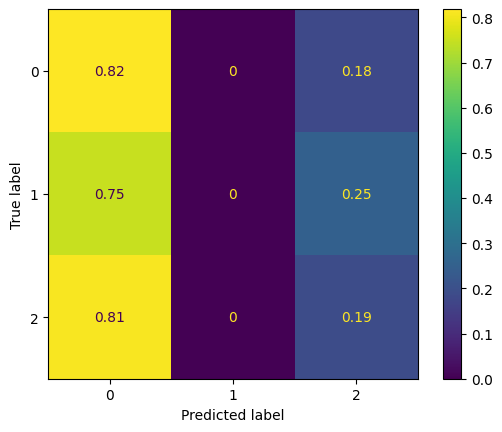



_________________________________


Training B_TABL...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_short(scratch)\B_TABL.pt
Epoch 1/20, Train Loss: 0.9129,           Validation Loss: 0.8654, Duration: 0:00:00.039999, Best Val Epoch: 0
Epoch 2/20, Train Loss: 0.7827,           Validation Loss: 0.9772, Duration: 0:00:00.037000, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:00<00:00, 27.03it/s]

Epoch 3/20, Train Loss: 0.7309,           Validation Loss: 0.8715, Duration: 0:00:00.034000, Best Val Epoch: 0
model saved at APPL_short(scratch)\B_TABL.pt
Epoch 4/20, Train Loss: 0.7170,           Validation Loss: 0.8644, Duration: 0:00:00.039004, Best Val Epoch: 3
Epoch 5/20, Train Loss: 0.7133,           Validation Loss: 0.9251, Duration: 0:00:00.035997, Best Val Epoch: 3
Epoch 6/20, Train Loss: 0.6770,           Validation Loss: 0.8726, Duration: 0:00:00.039999, Best Val Epoch: 3

 30%|███       | 6/20 [00:00<00:00, 26.47it/s]


Epoch 7/20, Train Loss: 0.6835,           Validation Loss: 0.9714, Duration: 0:00:00.034000, Best Val Epoch: 3
Epoch 8/20, Train Loss: 0.6829,           Validation Loss: 1.1106, Duration: 0:00:00.035000, Best Val Epoch: 3


 45%|████▌     | 9/20 [00:00<00:00, 27.50it/s]

Epoch 9/20, Train Loss: 0.6563,           Validation Loss: 0.9640, Duration: 0:00:00.034001, Best Val Epoch: 3
Epoch 10/20, Train Loss: 0.6450,           Validation Loss: 0.9402, Duration: 0:00:00.042002, Best Val Epoch: 3
Epoch 11/20, Train Loss: 0.6550,           Validation Loss: 1.0092, Duration: 0:00:00.039998, Best Val Epoch: 3


 60%|██████    | 12/20 [00:00<00:00, 26.55it/s]

Epoch 12/20, Train Loss: 0.6438,           Validation Loss: 1.0366, Duration: 0:00:00.036000, Best Val Epoch: 3
Epoch 13/20, Train Loss: 0.6115,           Validation Loss: 0.9717, Duration: 0:00:00.040000, Best Val Epoch: 3
Epoch 14/20, Train Loss: 0.6176,           Validation Loss: 1.0962, Duration: 0:00:00.036000, Best Val Epoch: 3


 75%|███████▌  | 15/20 [00:00<00:00, 26.89it/s]

Epoch 15/20, Train Loss: 0.6092,           Validation Loss: 1.0021, Duration: 0:00:00.032999, Best Val Epoch: 3
Epoch 16/20, Train Loss: 0.6155,           Validation Loss: 1.0926, Duration: 0:00:00.037000, Best Val Epoch: 3
Epoch 17/20, Train Loss: 0.5941,           Validation Loss: 1.0495, Duration: 0:00:00.034002, Best Val Epoch: 3


 90%|█████████ | 18/20 [00:00<00:00, 27.19it/s]

Epoch 18/20, Train Loss: 0.5823,           Validation Loss: 1.0450, Duration: 0:00:00.036999, Best Val Epoch: 3
Epoch 19/20, Train Loss: 0.5708,           Validation Loss: 1.0857, Duration: 0:00:00.033995, Best Val Epoch: 3
Epoch 20/20, Train Loss: 0.5581,           Validation Loss: 1.1116, Duration: 0:00:00.032999, Best Val Epoch: 3


100%|██████████| 20/20 [00:00<00:00, 27.17it/s]

Full time to train: 0:00:00.736997. Average time per epoch: 0:00:00.036850
Evaluating B_TABL on test set

Test acc: 0.5134. Test Loss: 0.8398. Time on test: 0:00:00.009002
              precision    recall  f1-score   support

           0     0.5038    0.8121    0.6218       165
           1     0.0000    0.0000    0.0000         4
           2     0.5493    0.2321    0.3264       168

    accuracy                         0.5134       337
   macro avg     0.3510    0.3481    0.3161       337
weighted avg     0.5205    0.5134    0.4671       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

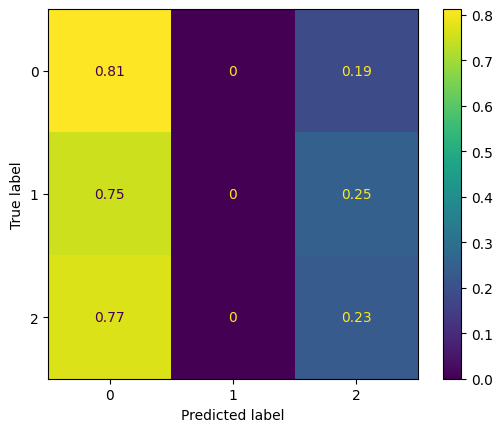



_________________________________


Training C_TABL...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_short(scratch)\C_TABL.pt
Epoch 1/20, Train Loss: 0.8427,           Validation Loss: 0.8177, Duration: 0:00:00.048001, Best Val Epoch: 0
model saved at APPL_short(scratch)\C_TABL.pt
Epoch 2/20, Train Loss: 0.7416,           Validation Loss: 0.8041, Duration: 0:00:00.045999, Best Val Epoch: 1


 15%|█▌        | 3/20 [00:00<00:00, 20.98it/s]

model saved at APPL_short(scratch)\C_TABL.pt
Epoch 3/20, Train Loss: 0.7002,           Validation Loss: 0.8037, Duration: 0:00:00.047001, Best Val Epoch: 2
Epoch 4/20, Train Loss: 0.6874,           Validation Loss: 0.8399, Duration: 0:00:00.042996, Best Val Epoch: 2
Epoch 5/20, Train Loss: 0.6742,           Validation Loss: 1.0313, Duration: 0:00:00.040000, Best Val Epoch: 2

 30%|███       | 6/20 [00:00<00:00, 22.26it/s]


Epoch 6/20, Train Loss: 0.6723,           Validation Loss: 0.9279, Duration: 0:00:00.045000, Best Val Epoch: 2
Epoch 7/20, Train Loss: 0.6591,           Validation Loss: 0.8839, Duration: 0:00:00.039000, Best Val Epoch: 2
Epoch 8/20, Train Loss: 0.6394,           Validation Loss: 0.9871, Duration: 0:00:00.037000, Best Val Epoch: 2


 45%|████▌     | 9/20 [00:00<00:00, 23.69it/s]

Epoch 9/20, Train Loss: 0.6376,           Validation Loss: 0.9533, Duration: 0:00:00.040000, Best Val Epoch: 2
Epoch 10/20, Train Loss: 0.6149,           Validation Loss: 1.0085, Duration: 0:00:00.042001, Best Val Epoch: 2


 60%|██████    | 12/20 [00:00<00:00, 23.74it/s]

Epoch 11/20, Train Loss: 0.5929,           Validation Loss: 0.9645, Duration: 0:00:00.041997, Best Val Epoch: 2
Epoch 12/20, Train Loss: 0.5996,           Validation Loss: 1.1941, Duration: 0:00:00.041000, Best Val Epoch: 2
Epoch 13/20, Train Loss: 0.6016,           Validation Loss: 0.9345, Duration: 0:00:00.043000, Best Val Epoch: 2
Epoch 14/20, Train Loss: 0.5600,           Validation Loss: 1.2100, Duration: 0:00:00.039000, Best Val Epoch: 2


 75%|███████▌  | 15/20 [00:00<00:00, 23.83it/s]

Epoch 15/20, Train Loss: 0.5664,           Validation Loss: 1.0302, Duration: 0:00:00.042002, Best Val Epoch: 2


 90%|█████████ | 18/20 [00:00<00:00, 23.95it/s]

Epoch 16/20, Train Loss: 0.5808,           Validation Loss: 1.2038, Duration: 0:00:00.039999, Best Val Epoch: 2
Epoch 17/20, Train Loss: 0.5697,           Validation Loss: 0.9672, Duration: 0:00:00.041998, Best Val Epoch: 2
Epoch 18/20, Train Loss: 0.5578,           Validation Loss: 1.0333, Duration: 0:00:00.040000, Best Val Epoch: 2
Epoch 19/20, Train Loss: 0.5207,           Validation Loss: 1.0369, Duration: 0:00:00.042997, Best Val Epoch: 2
Epoch 20/20, Train Loss: 0.5018,           Validation Loss: 1.1640, Duration: 0:00:00.039001, Best Val Epoch: 2


100%|██████████| 20/20 [00:00<00:00, 23.61it/s]

Full time to train: 0:00:00.849002. Average time per epoch: 0:00:00.042450
Evaluating C_TABL on test set

Test acc: 0.5015. Test Loss: 0.7851. Time on test: 0:00:00.006001
              precision    recall  f1-score   support

           0     0.5000    0.6606    0.5692       165
           1     0.0000    0.0000    0.0000         4
           2     0.5042    0.3571    0.4181       168

    accuracy                         0.5015       337
   macro avg     0.3347    0.3392    0.3291       337
weighted avg     0.4962    0.5015    0.4871       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

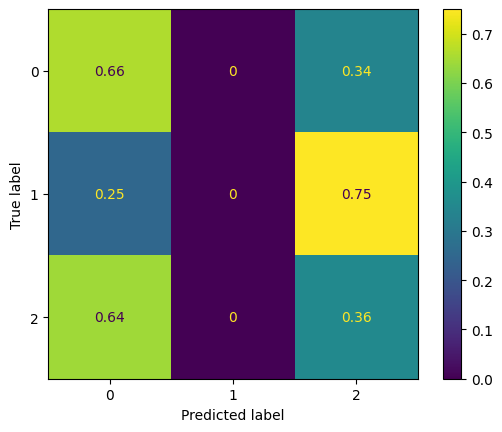



_________________________________


Training DeepLOBSeq2Seq...


  5%|▌         | 1/20 [00:00<00:01, 10.00it/s]

model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt
Epoch 1/20, Train Loss: 0.9633,           Validation Loss: 0.7677, Duration: 0:00:00.100001, Best Val Epoch: 0
model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt
Epoch 2/20, Train Loss: 0.7521,           Validation Loss: 0.7548, Duration: 0:00:00.097000, Best Val Epoch: 1
model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt

 15%|█▌        | 3/20 [00:00<00:01, 10.31it/s]


Epoch 3/20, Train Loss: 0.7422,           Validation Loss: 0.7456, Duration: 0:00:00.094998, Best Val Epoch: 2
Epoch 4/20, Train Loss: 0.7474,           Validation Loss: 0.7634, Duration: 0:00:00.101002, Best Val Epoch: 2


 25%|██▌       | 5/20 [00:00<00:01,  9.99it/s]

Epoch 5/20, Train Loss: 0.7413,           Validation Loss: 0.7490, Duration: 0:00:00.104999, Best Val Epoch: 2
Epoch 6/20, Train Loss: 0.7366,           Validation Loss: 0.7473, Duration: 0:00:00.094000, Best Val Epoch: 2
model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt
Epoch 7/20, Train Loss: 0.7336,           Validation Loss: 0.7421, Duration: 0:00:00.092000, Best Val Epoch: 6


 45%|████▌     | 9/20 [00:00<00:01, 10.28it/s]

Epoch 8/20, Train Loss: 0.7358,           Validation Loss: 0.7514, Duration: 0:00:00.091000, Best Val Epoch: 6
Epoch 9/20, Train Loss: 0.7357,           Validation Loss: 0.7613, Duration: 0:00:00.103002, Best Val Epoch: 6


 55%|█████▌    | 11/20 [00:01<00:00, 10.24it/s]

Epoch 10/20, Train Loss: 0.7350,           Validation Loss: 0.7529, Duration: 0:00:00.101999, Best Val Epoch: 6
Epoch 11/20, Train Loss: 0.7312,           Validation Loss: 0.7448, Duration: 0:00:00.094004, Best Val Epoch: 6
Epoch 12/20, Train Loss: 0.7355,           Validation Loss: 0.7479, Duration: 0:00:00.095998, Best Val Epoch: 6


 65%|██████▌   | 13/20 [00:01<00:00, 10.35it/s]

Epoch 13/20, Train Loss: 0.7302,           Validation Loss: 0.7464, Duration: 0:00:00.092000, Best Val Epoch: 6
Epoch 14/20, Train Loss: 0.7266,           Validation Loss: 0.7589, Duration: 0:00:00.106000, Best Val Epoch: 6
model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt
Epoch 15/20, Train Loss: 0.7292,           Validation Loss: 0.7403, Duration: 0:00:00.092000, Best Val Epoch: 14


 85%|████████▌ | 17/20 [00:01<00:00, 10.46it/s]

Epoch 16/20, Train Loss: 0.7321,           Validation Loss: 0.7496, Duration: 0:00:00.089999, Best Val Epoch: 14
model saved at APPL_short(scratch)\DeepLOBSeq2Seq.pt
Epoch 17/20, Train Loss: 0.7269,           Validation Loss: 0.7321, Duration: 0:00:00.092001, Best Val Epoch: 16
Epoch 18/20, Train Loss: 0.7285,           Validation Loss: 0.7624, Duration: 0:00:00.099999, Best Val Epoch: 16


100%|██████████| 20/20 [00:01<00:00, 10.33it/s]

Epoch 19/20, Train Loss: 0.7240,           Validation Loss: 0.7583, Duration: 0:00:00.092001, Best Val Epoch: 16
Epoch 20/20, Train Loss: 0.7261,           Validation Loss: 0.7358, Duration: 0:00:00.098000, Best Val Epoch: 16
Full time to train: 0:00:01.938000. Average time per epoch: 0:00:00.096900
Evaluating DeepLOBSeq2Seq on test set

Test acc: 0.5727. Test Loss: 0.7269. Time on test: 0:00:00.010000
              precision    recall  f1-score   support

           0     0.5439    0.7879    0.6436       165
           1     0.0000    0.0000    0.0000         4
           2     0.6429    0.3750    0.4737       168

    accuracy                         0.5727       337
   macro avg     0.3956    0.3876    0.3724       337
weighted avg     0.5868    0.5727    0.5512       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

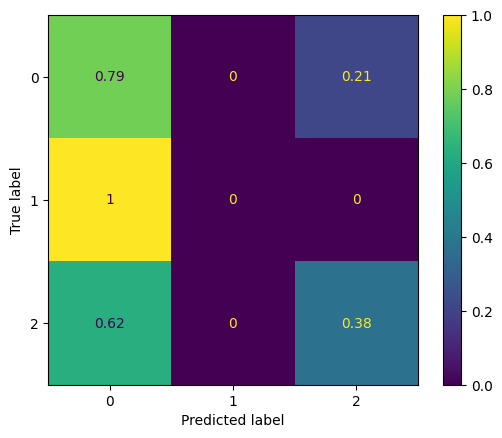



_________________________________


Training DeepLOBAttention...


 10%|█         | 2/20 [00:00<00:01, 11.11it/s]

model saved at APPL_short(scratch)\DeepLOBAttention.pt
Epoch 1/20, Train Loss: 0.9143,           Validation Loss: 0.8144, Duration: 0:00:00.094001, Best Val Epoch: 0
model saved at APPL_short(scratch)\DeepLOBAttention.pt
Epoch 2/20, Train Loss: 0.7588,           Validation Loss: 0.7510, Duration: 0:00:00.086000, Best Val Epoch: 1
Epoch 3/20, Train Loss: 0.7376,           Validation Loss: 0.8048, Duration: 0:00:00.084999, Best Val Epoch: 1


 20%|██        | 4/20 [00:00<00:01, 11.76it/s]

model saved at APPL_short(scratch)\DeepLOBAttention.pt
Epoch 4/20, Train Loss: 0.7383,           Validation Loss: 0.7453, Duration: 0:00:00.076002, Best Val Epoch: 3
Epoch 5/20, Train Loss: 0.7362,           Validation Loss: 0.7682, Duration: 0:00:00.084998, Best Val Epoch: 3


 30%|███       | 6/20 [00:00<00:01, 11.55it/s]

Epoch 6/20, Train Loss: 0.7350,           Validation Loss: 0.7514, Duration: 0:00:00.092001, Best Val Epoch: 3


 40%|████      | 8/20 [00:00<00:01, 11.71it/s]

Epoch 7/20, Train Loss: 0.7336,           Validation Loss: 0.7540, Duration: 0:00:00.089000, Best Val Epoch: 3
Epoch 8/20, Train Loss: 0.7324,           Validation Loss: 0.7606, Duration: 0:00:00.077000, Best Val Epoch: 3
Epoch 9/20, Train Loss: 0.7319,           Validation Loss: 0.7714, Duration: 0:00:00.089999, Best Val Epoch: 3


 50%|█████     | 10/20 [00:00<00:00, 11.49it/s]

Epoch 10/20, Train Loss: 0.7305,           Validation Loss: 0.7527, Duration: 0:00:00.088002, Best Val Epoch: 3
Epoch 11/20, Train Loss: 0.7313,           Validation Loss: 0.7545, Duration: 0:00:00.080999, Best Val Epoch: 3


 60%|██████    | 12/20 [00:01<00:00, 11.65it/s]

Epoch 12/20, Train Loss: 0.7271,           Validation Loss: 0.7620, Duration: 0:00:00.086002, Best Val Epoch: 3


 70%|███████   | 14/20 [00:01<00:00, 11.69it/s]

Epoch 13/20, Train Loss: 0.7242,           Validation Loss: 0.7732, Duration: 0:00:00.082000, Best Val Epoch: 3
Epoch 14/20, Train Loss: 0.7271,           Validation Loss: 0.7671, Duration: 0:00:00.086999, Best Val Epoch: 3
Epoch 15/20, Train Loss: 0.7233,           Validation Loss: 0.7759, Duration: 0:00:00.085999, Best Val Epoch: 3


 80%|████████  | 16/20 [00:01<00:00, 11.63it/s]

Epoch 16/20, Train Loss: 0.7210,           Validation Loss: 0.7823, Duration: 0:00:00.086003, Best Val Epoch: 3
Epoch 17/20, Train Loss: 0.7246,           Validation Loss: 0.7773, Duration: 0:00:00.077999, Best Val Epoch: 3


 90%|█████████ | 18/20 [00:01<00:00, 11.63it/s]

Epoch 18/20, Train Loss: 0.7194,           Validation Loss: 0.7813, Duration: 0:00:00.094001, Best Val Epoch: 3
Epoch 19/20, Train Loss: 0.7200,           Validation Loss: 0.7873, Duration: 0:00:00.091999, Best Val Epoch: 3
Epoch 20/20, Train Loss: 0.7167,           Validation Loss: 0.7990, Duration: 0:00:00.085000, Best Val Epoch: 3


100%|██████████| 20/20 [00:01<00:00, 11.56it/s]

Full time to train: 0:00:01.731001. Average time per epoch: 0:00:00.086550
Evaluating DeepLOBAttention on test set

Test acc: 0.5074. Test Loss: 0.7414. Time on test: 0:00:00.009000
              precision    recall  f1-score   support

           0     0.6364    0.0424    0.0795       165
           1     0.0000    0.0000    0.0000         4
           2     0.5031    0.9762    0.6640       168

    accuracy                         0.5074       337
   macro avg     0.3798    0.3395    0.2478       337
weighted avg     0.5624    0.5074    0.3699       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

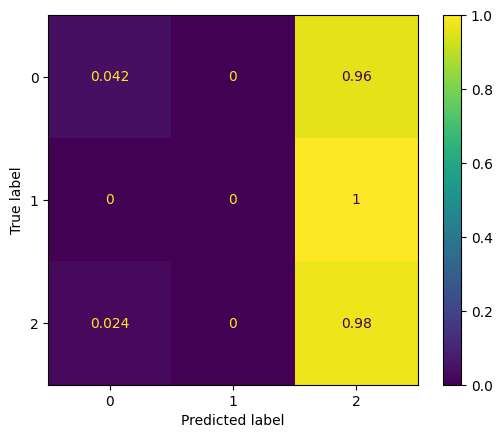



_________________________________




In [ ]:
print("Train models from scratch on AAPL data")
evaluate_all(get_models_to_test(False, None), epochs, train_loader_short, val_loader_short, test_loader_short, train_model=TRAIN_APPL, save_dir=save_loc + "_short(scratch)")

C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\438007077.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_to_test[model_name].load_state_dict(torch.load(_save_p

Train pre-trained models from FI-2010 on APPL data
Attempting to load from pretrained...
All models loaded successfully
Training AxialLOB...


  5%|▌         | 1/20 [00:02<00:42,  2.23s/it]

model saved at APPL_short(pretrained)\AxialLOB.pt
Epoch 1/20, Train Loss: 1.0489,           Validation Loss: 0.9633, Duration: 0:00:02.227505, Best Val Epoch: 0


 10%|█         | 2/20 [00:04<00:37,  2.06s/it]

Epoch 2/20, Train Loss: 0.9876,           Validation Loss: 1.0235, Duration: 0:00:01.943227, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:06<00:34,  2.01s/it]

Epoch 3/20, Train Loss: 0.9636,           Validation Loss: 1.0037, Duration: 0:00:01.952982, Best Val Epoch: 0


 20%|██        | 4/20 [00:08<00:31,  1.99s/it]

Epoch 4/20, Train Loss: 0.9533,           Validation Loss: 0.9746, Duration: 0:00:01.956000, Best Val Epoch: 0
Turning on additional grads for AxialLOB...


 25%|██▌       | 5/20 [00:10<00:30,  2.01s/it]

Epoch 5/20, Train Loss: 0.9094,           Validation Loss: 1.0336, Duration: 0:00:02.033998, Best Val Epoch: 0


 30%|███       | 6/20 [00:12<00:28,  2.02s/it]

Epoch 6/20, Train Loss: 0.9025,           Validation Loss: 1.0492, Duration: 0:00:02.032000, Best Val Epoch: 0


 35%|███▌      | 7/20 [00:14<00:26,  2.02s/it]

Epoch 7/20, Train Loss: 0.8799,           Validation Loss: 1.0197, Duration: 0:00:02.016000, Best Val Epoch: 0


 40%|████      | 8/20 [00:16<00:24,  2.02s/it]

Epoch 8/20, Train Loss: 0.8557,           Validation Loss: 1.0614, Duration: 0:00:02.016000, Best Val Epoch: 0


 45%|████▌     | 9/20 [00:18<00:22,  2.02s/it]

Epoch 9/20, Train Loss: 0.8397,           Validation Loss: 1.0261, Duration: 0:00:02.016997, Best Val Epoch: 0


 50%|█████     | 10/20 [00:20<00:20,  2.02s/it]

Epoch 10/20, Train Loss: 0.8317,           Validation Loss: 1.0355, Duration: 0:00:02.014040, Best Val Epoch: 0


 55%|█████▌    | 11/20 [00:22<00:18,  2.02s/it]

Epoch 11/20, Train Loss: 0.8282,           Validation Loss: 1.0266, Duration: 0:00:02.014999, Best Val Epoch: 0


 60%|██████    | 12/20 [00:24<00:16,  2.02s/it]

Epoch 12/20, Train Loss: 0.8139,           Validation Loss: 1.0518, Duration: 0:00:02.014000, Best Val Epoch: 0


 65%|██████▌   | 13/20 [00:26<00:14,  2.02s/it]

Epoch 13/20, Train Loss: 0.7942,           Validation Loss: 1.0575, Duration: 0:00:02.020997, Best Val Epoch: 0


 70%|███████   | 14/20 [00:28<00:12,  2.02s/it]

Epoch 14/20, Train Loss: 0.7789,           Validation Loss: 1.0923, Duration: 0:00:02.028999, Best Val Epoch: 0


 75%|███████▌  | 15/20 [00:30<00:10,  2.02s/it]

Epoch 15/20, Train Loss: 0.7793,           Validation Loss: 1.0852, Duration: 0:00:02.026002, Best Val Epoch: 0


 80%|████████  | 16/20 [00:32<00:08,  2.02s/it]

Epoch 16/20, Train Loss: 0.7640,           Validation Loss: 1.1094, Duration: 0:00:02.028999, Best Val Epoch: 0


 85%|████████▌ | 17/20 [00:34<00:06,  2.03s/it]

Epoch 17/20, Train Loss: 0.7583,           Validation Loss: 1.0984, Duration: 0:00:02.025000, Best Val Epoch: 0


 90%|█████████ | 18/20 [00:36<00:04,  2.03s/it]

Epoch 18/20, Train Loss: 0.7340,           Validation Loss: 1.1146, Duration: 0:00:02.035996, Best Val Epoch: 0


 95%|█████████▌| 19/20 [00:38<00:02,  2.03s/it]

Epoch 19/20, Train Loss: 0.7269,           Validation Loss: 1.0728, Duration: 0:00:02.038001, Best Val Epoch: 0


100%|██████████| 20/20 [00:40<00:00,  2.02s/it]

Epoch 20/20, Train Loss: 0.7295,           Validation Loss: 1.1079, Duration: 0:00:02.039998, Best Val Epoch: 0
Full time to train: 0:00:40.500764. Average time per epoch: 0:00:02.025038
Evaluating AxialLOB on test set

Test acc: 0.4866. Test Loss: 1.0109. Time on test: 0:00:00.121000
              precision    recall  f1-score   support

           0     0.4810    0.6121    0.5387       165
           1     0.0000    0.0000    0.0000         4
           2     0.4961    0.3750    0.4271       168

    accuracy                         0.4866       337
   macro avg     0.3257    0.3290    0.3219       337
weighted avg     0.4828    0.4866    0.4767       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

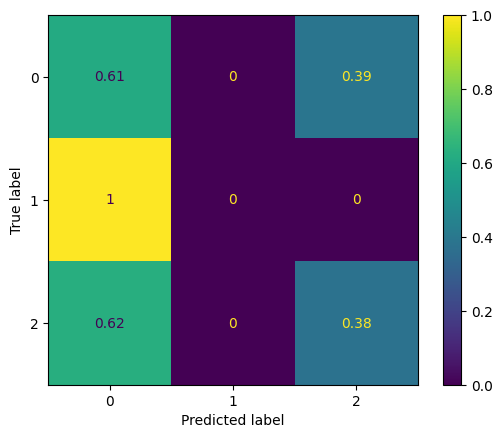



_________________________________


Training DeepLOB...


  5%|▌         | 1/20 [00:00<00:04,  4.24it/s]

model saved at APPL_short(pretrained)\DeepLOB.pt
Epoch 1/20, Train Loss: 0.7949,           Validation Loss: 0.7611, Duration: 0:00:00.235995, Best Val Epoch: 0


 10%|█         | 2/20 [00:00<00:04,  4.25it/s]

model saved at APPL_short(pretrained)\DeepLOB.pt
Epoch 2/20, Train Loss: 0.7352,           Validation Loss: 0.7585, Duration: 0:00:00.234001, Best Val Epoch: 1


 15%|█▌        | 3/20 [00:00<00:03,  4.34it/s]

Epoch 3/20, Train Loss: 0.7094,           Validation Loss: 0.7792, Duration: 0:00:00.222999, Best Val Epoch: 1


 20%|██        | 4/20 [00:00<00:03,  4.38it/s]

Epoch 4/20, Train Loss: 0.6778,           Validation Loss: 0.8681, Duration: 0:00:00.224001, Best Val Epoch: 1


 25%|██▌       | 5/20 [00:01<00:03,  4.42it/s]

Epoch 5/20, Train Loss: 0.6484,           Validation Loss: 0.7874, Duration: 0:00:00.223000, Best Val Epoch: 1


 30%|███       | 6/20 [00:01<00:03,  4.43it/s]

Epoch 6/20, Train Loss: 0.6269,           Validation Loss: 0.8750, Duration: 0:00:00.222997, Best Val Epoch: 1


 35%|███▌      | 7/20 [00:01<00:02,  4.45it/s]

Epoch 7/20, Train Loss: 0.5539,           Validation Loss: 0.8818, Duration: 0:00:00.223000, Best Val Epoch: 1


 40%|████      | 8/20 [00:01<00:02,  4.42it/s]

Epoch 8/20, Train Loss: 0.4895,           Validation Loss: 0.8460, Duration: 0:00:00.226995, Best Val Epoch: 1


 45%|████▌     | 9/20 [00:02<00:02,  4.42it/s]

Epoch 9/20, Train Loss: 0.4092,           Validation Loss: 1.0999, Duration: 0:00:00.225001, Best Val Epoch: 1


 50%|█████     | 10/20 [00:02<00:02,  4.43it/s]

Epoch 10/20, Train Loss: 0.3341,           Validation Loss: 1.1511, Duration: 0:00:00.224999, Best Val Epoch: 1


 55%|█████▌    | 11/20 [00:02<00:02,  4.42it/s]

Epoch 11/20, Train Loss: 0.2420,           Validation Loss: 1.3689, Duration: 0:00:00.227999, Best Val Epoch: 1


 60%|██████    | 12/20 [00:02<00:01,  4.42it/s]

Epoch 12/20, Train Loss: 0.1773,           Validation Loss: 1.4908, Duration: 0:00:00.222998, Best Val Epoch: 1


 65%|██████▌   | 13/20 [00:02<00:01,  4.43it/s]

Epoch 13/20, Train Loss: 0.1597,           Validation Loss: 1.6264, Duration: 0:00:00.224000, Best Val Epoch: 1


 70%|███████   | 14/20 [00:03<00:01,  4.44it/s]

Epoch 14/20, Train Loss: 0.1065,           Validation Loss: 1.7030, Duration: 0:00:00.223999, Best Val Epoch: 1


 75%|███████▌  | 15/20 [00:03<00:01,  4.43it/s]

Epoch 15/20, Train Loss: 0.0676,           Validation Loss: 1.7868, Duration: 0:00:00.224999, Best Val Epoch: 1


 80%|████████  | 16/20 [00:03<00:00,  4.43it/s]

Epoch 16/20, Train Loss: 0.0551,           Validation Loss: 1.7930, Duration: 0:00:00.224997, Best Val Epoch: 1


 85%|████████▌ | 17/20 [00:03<00:00,  4.43it/s]

Epoch 17/20, Train Loss: 0.0322,           Validation Loss: 1.9274, Duration: 0:00:00.224998, Best Val Epoch: 1


 90%|█████████ | 18/20 [00:04<00:00,  4.44it/s]

Epoch 18/20, Train Loss: 0.0173,           Validation Loss: 2.1203, Duration: 0:00:00.221999, Best Val Epoch: 1


 95%|█████████▌| 19/20 [00:04<00:00,  4.44it/s]

Epoch 19/20, Train Loss: 0.0116,           Validation Loss: 2.2710, Duration: 0:00:00.226001, Best Val Epoch: 1


100%|██████████| 20/20 [00:04<00:00,  4.42it/s]

Epoch 20/20, Train Loss: 0.0136,           Validation Loss: 2.2912, Duration: 0:00:00.224997, Best Val Epoch: 1
Full time to train: 0:00:04.529998. Average time per epoch: 0:00:00.226500
Evaluating DeepLOB on test set

Test acc: 0.5460. Test Loss: 0.7410. Time on test: 0:00:00.019999
              precision    recall  f1-score   support

           0     0.5254    0.7515    0.6185       165
           1     0.0000    0.0000    0.0000         4
           2     0.5941    0.3571    0.4461       168

    accuracy                         0.5460       337
   macro avg     0.3732    0.3696    0.3549       337
weighted avg     0.5534    0.5460    0.5252       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

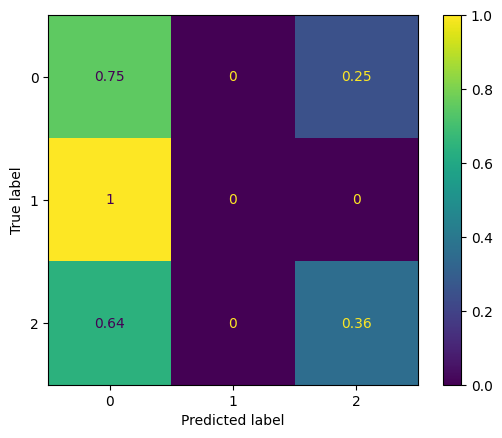



_________________________________


Training B_TABL...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_short(pretrained)\B_TABL.pt
Epoch 1/20, Train Loss: 1.2436,           Validation Loss: 0.9004, Duration: 0:00:00.042001, Best Val Epoch: 0


 15%|█▌        | 3/20 [00:00<00:00, 26.32it/s]

model saved at APPL_short(pretrained)\B_TABL.pt
Epoch 2/20, Train Loss: 0.7879,           Validation Loss: 0.8565, Duration: 0:00:00.036999, Best Val Epoch: 1
Epoch 3/20, Train Loss: 0.6838,           Validation Loss: 0.9387, Duration: 0:00:00.035000, Best Val Epoch: 1
Epoch 4/20, Train Loss: 0.6785,           Validation Loss: 0.9020, Duration: 0:00:00.038002, Best Val Epoch: 1
Epoch 5/20, Train Loss: 0.6834,           Validation Loss: 0.9116, Duration: 0:00:00.042999, Best Val Epoch: 1


 30%|███       | 6/20 [00:00<00:00, 25.27it/s]

Epoch 6/20, Train Loss: 0.6553,           Validation Loss: 1.0695, Duration: 0:00:00.039000, Best Val Epoch: 1
Epoch 7/20, Train Loss: 0.6185,           Validation Loss: 1.0430, Duration: 0:00:00.037000, Best Val Epoch: 1


 60%|██████    | 12/20 [00:00<00:00, 27.23it/s]

Epoch 8/20, Train Loss: 0.5913,           Validation Loss: 1.1974, Duration: 0:00:00.033000, Best Val Epoch: 1
Epoch 9/20, Train Loss: 0.5854,           Validation Loss: 1.0115, Duration: 0:00:00.035002, Best Val Epoch: 1
Epoch 10/20, Train Loss: 0.5760,           Validation Loss: 1.0005, Duration: 0:00:00.035998, Best Val Epoch: 1
Epoch 11/20, Train Loss: 0.5666,           Validation Loss: 1.0327, Duration: 0:00:00.035000, Best Val Epoch: 1
Epoch 12/20, Train Loss: 0.5480,           Validation Loss: 1.1874, Duration: 0:00:00.035001, Best Val Epoch: 1
Epoch 13/20, Train Loss: 0.5489,           Validation Loss: 1.0819, Duration: 0:00:00.037000, Best Val Epoch: 1

 90%|█████████ | 18/20 [00:00<00:00, 27.31it/s]


Epoch 14/20, Train Loss: 0.5287,           Validation Loss: 1.1841, Duration: 0:00:00.035999, Best Val Epoch: 1
Epoch 15/20, Train Loss: 0.5198,           Validation Loss: 1.4096, Duration: 0:00:00.035000, Best Val Epoch: 1
Epoch 16/20, Train Loss: 0.5136,           Validation Loss: 1.1238, Duration: 0:00:00.038001, Best Val Epoch: 1
Epoch 17/20, Train Loss: 0.5089,           Validation Loss: 1.1764, Duration: 0:00:00.038001, Best Val Epoch: 1
Epoch 18/20, Train Loss: 0.4913,           Validation Loss: 1.2267, Duration: 0:00:00.033998, Best Val Epoch: 1


100%|██████████| 20/20 [00:00<00:00, 27.06it/s]

Epoch 19/20, Train Loss: 0.5011,           Validation Loss: 1.2029, Duration: 0:00:00.034002, Best Val Epoch: 1
Epoch 20/20, Train Loss: 0.4834,           Validation Loss: 1.2734, Duration: 0:00:00.036999, Best Val Epoch: 1
Full time to train: 0:00:00.741000. Average time per epoch: 0:00:00.037050
Evaluating B_TABL on test set

Test acc: 0.5074. Test Loss: 0.8365. Time on test: 0:00:00.005999
              precision    recall  f1-score   support

           0     0.4977    0.6485    0.5632       165
           1     0.0000    0.0000    0.0000         4
           2     0.5246    0.3810    0.4414       168

    accuracy                         0.5074       337
   macro avg     0.3408    0.3431    0.3348       337
weighted avg     0.5052    0.5074    0.4958       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

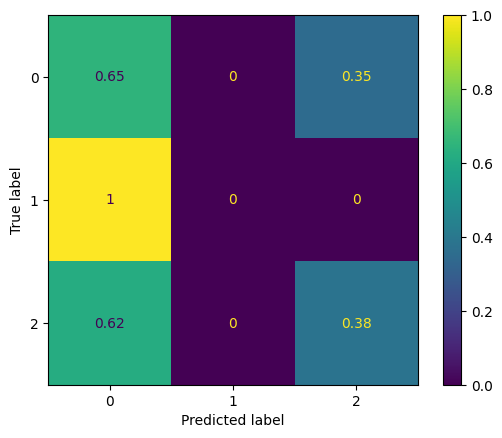



_________________________________


Training C_TABL...


  0%|          | 0/20 [00:00<?, ?it/s]

model saved at APPL_short(pretrained)\C_TABL.pt

 15%|█▌        | 3/20 [00:00<00:00, 21.28it/s]


Epoch 1/20, Train Loss: 0.9320,           Validation Loss: 0.7797, Duration: 0:00:00.053998, Best Val Epoch: 0
model saved at APPL_short(pretrained)\C_TABL.pt
Epoch 2/20, Train Loss: 0.7391,           Validation Loss: 0.7749, Duration: 0:00:00.044000, Best Val Epoch: 1
Epoch 3/20, Train Loss: 0.7164,           Validation Loss: 0.8006, Duration: 0:00:00.043000, Best Val Epoch: 1
Epoch 4/20, Train Loss: 0.6885,           Validation Loss: 0.8302, Duration: 0:00:00.043001, Best Val Epoch: 1
Epoch 5/20, Train Loss: 0.6769,           Validation Loss: 0.7952, Duration: 0:00:00.042998, Best Val Epoch: 1


 45%|████▌     | 9/20 [00:00<00:00, 22.96it/s]

Epoch 6/20, Train Loss: 0.6603,           Validation Loss: 0.8020, Duration: 0:00:00.044001, Best Val Epoch: 1
Epoch 7/20, Train Loss: 0.6495,           Validation Loss: 0.8019, Duration: 0:00:00.041000, Best Val Epoch: 1
Epoch 8/20, Train Loss: 0.6280,           Validation Loss: 0.8427, Duration: 0:00:00.043000, Best Val Epoch: 1
Epoch 9/20, Train Loss: 0.6188,           Validation Loss: 0.9464, Duration: 0:00:00.040999, Best Val Epoch: 1
Epoch 10/20, Train Loss: 0.6217,           Validation Loss: 0.8002, Duration: 0:00:00.042999, Best Val Epoch: 1
Epoch 11/20, Train Loss: 0.6031,           Validation Loss: 0.7988, Duration: 0:00:00.040001, Best Val Epoch: 1


 60%|██████    | 12/20 [00:00<00:00, 23.15it/s]

Epoch 12/20, Train Loss: 0.5897,           Validation Loss: 0.8181, Duration: 0:00:00.044001, Best Val Epoch: 1
Epoch 13/20, Train Loss: 0.5818,           Validation Loss: 0.8399, Duration: 0:00:00.040000, Best Val Epoch: 1
Epoch 14/20, Train Loss: 0.5641,           Validation Loss: 0.8245, Duration: 0:00:00.044003, Best Val Epoch: 1


 75%|███████▌  | 15/20 [00:00<00:00, 22.87it/s]

Epoch 15/20, Train Loss: 0.5532,           Validation Loss: 0.8479, Duration: 0:00:00.047997, Best Val Epoch: 1
Epoch 16/20, Train Loss: 0.5714,           Validation Loss: 0.8394, Duration: 0:00:00.045999, Best Val Epoch: 1


 90%|█████████ | 18/20 [00:00<00:00, 22.82it/s]

Epoch 17/20, Train Loss: 0.5587,           Validation Loss: 0.8331, Duration: 0:00:00.043000, Best Val Epoch: 1
Epoch 18/20, Train Loss: 0.5514,           Validation Loss: 1.0593, Duration: 0:00:00.041999, Best Val Epoch: 1
Epoch 19/20, Train Loss: 0.5400,           Validation Loss: 0.8215, Duration: 0:00:00.047999, Best Val Epoch: 1


100%|██████████| 20/20 [00:00<00:00, 22.57it/s]

Epoch 20/20, Train Loss: 0.5280,           Validation Loss: 0.8333, Duration: 0:00:00.045000, Best Val Epoch: 1
Full time to train: 0:00:00.886997. Average time per epoch: 0:00:00.044350
Evaluating C_TABL on test set

Test acc: 0.5045. Test Loss: 0.7982. Time on test: 0:00:00.007000
              precision    recall  f1-score   support

           0     0.5333    0.0970    0.1641       165
           1     0.0000    0.0000    0.0000         4
           2     0.5016    0.9167    0.6484       168

    accuracy                         0.5045       337
   macro avg     0.3450    0.3379    0.2708       337
weighted avg     0.5112    0.5045    0.4036       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

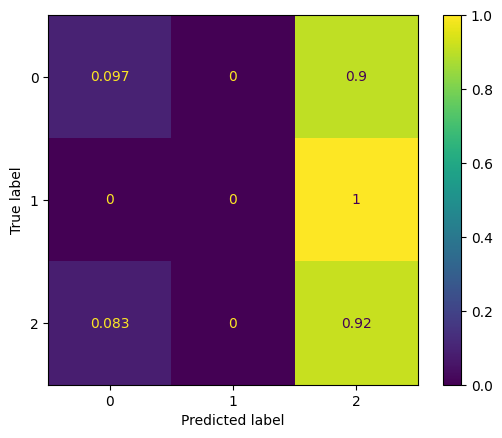



_________________________________


Training DeepLOBSeq2Seq...


  5%|▌         | 1/20 [00:00<00:01,  9.52it/s]

model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 1/20, Train Loss: 1.2168,           Validation Loss: 0.9025, Duration: 0:00:00.105002, Best Val Epoch: 0
model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 2/20, Train Loss: 0.7933,           Validation Loss: 0.7542, Duration: 0:00:00.097997, Best Val Epoch: 1
Epoch 3/20, Train Loss: 0.7321,           Validation Loss: 0.7577, Duration: 0:00:00.094000, Best Val Epoch: 1

 15%|█▌        | 3/20 [00:00<00:01, 10.17it/s]


Epoch 4/20, Train Loss: 0.7142,           Validation Loss: 0.7712, Duration: 0:00:00.097000, Best Val Epoch: 1
model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 5/20, Train Loss: 0.7150,           Validation Loss: 0.7467, Duration: 0:00:00.098000, Best Val Epoch: 4


 35%|███▌      | 7/20 [00:00<00:01, 10.11it/s]

model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 6/20, Train Loss: 0.7016,           Validation Loss: 0.7381, Duration: 0:00:00.101998, Best Val Epoch: 5
model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 7/20, Train Loss: 0.6962,           Validation Loss: 0.7289, Duration: 0:00:00.097002, Best Val Epoch: 6
model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 8/20, Train Loss: 0.6943,           Validation Loss: 0.7258, Duration: 0:00:00.098997, Best Val Epoch: 7


 45%|████▌     | 9/20 [00:00<00:01, 10.14it/s]

model saved at APPL_short(pretrained)\DeepLOBSeq2Seq.pt
Epoch 9/20, Train Loss: 0.6794,           Validation Loss: 0.7106, Duration: 0:00:00.095999, Best Val Epoch: 8
Epoch 10/20, Train Loss: 0.6848,           Validation Loss: 0.7465, Duration: 0:00:00.094999, Best Val Epoch: 8
Epoch 11/20, Train Loss: 0.6692,           Validation Loss: 0.7237, Duration: 0:00:00.094999, Best Val Epoch: 8


 65%|██████▌   | 13/20 [00:01<00:00, 10.40it/s]

Epoch 12/20, Train Loss: 0.6707,           Validation Loss: 0.7720, Duration: 0:00:00.092000, Best Val Epoch: 8
Epoch 13/20, Train Loss: 0.6672,           Validation Loss: 0.7482, Duration: 0:00:00.092998, Best Val Epoch: 8
Epoch 14/20, Train Loss: 0.6475,           Validation Loss: 0.7286, Duration: 0:00:00.096000, Best Val Epoch: 8


 75%|███████▌  | 15/20 [00:01<00:00, 10.40it/s]

Epoch 15/20, Train Loss: 0.6308,           Validation Loss: 0.7897, Duration: 0:00:00.094999, Best Val Epoch: 8
Epoch 16/20, Train Loss: 0.6191,           Validation Loss: 0.7612, Duration: 0:00:00.089997, Best Val Epoch: 8
Epoch 17/20, Train Loss: 0.6141,           Validation Loss: 0.7355, Duration: 0:00:00.092001, Best Val Epoch: 8


100%|██████████| 20/20 [00:01<00:00, 10.43it/s]

Epoch 18/20, Train Loss: 0.6104,           Validation Loss: 0.7428, Duration: 0:00:00.098999, Best Val Epoch: 8
Epoch 19/20, Train Loss: 0.5986,           Validation Loss: 0.7858, Duration: 0:00:00.086997, Best Val Epoch: 8
Epoch 20/20, Train Loss: 0.5862,           Validation Loss: 0.7387, Duration: 0:00:00.087999, Best Val Epoch: 8
Full time to train: 0:00:01.919994. Average time per epoch: 0:00:00.096000
Evaluating DeepLOBSeq2Seq on test set

Test acc: 0.5579. Test Loss: 0.7506. Time on test: 0:00:00.010000
              precision    recall  f1-score   support

           0     0.5354    0.7333    0.6189       165
           1     0.0000    0.0000    0.0000         4
           2     0.6036    0.3988    0.4803       168

    accuracy                         0.5579       337
   macro avg     0.3797    0.3774    0.3664       337
weighted avg     0.5630    0.5579    0.5425       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

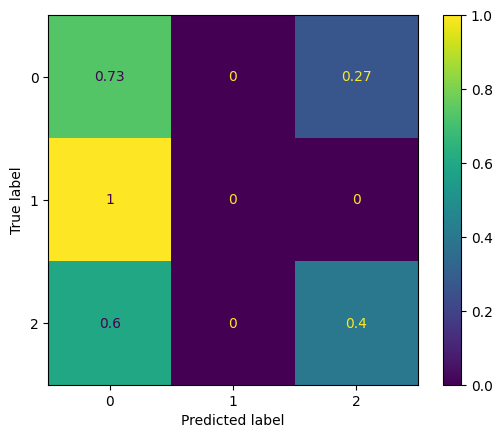



_________________________________


Training DeepLOBAttention...


  5%|▌         | 1/20 [00:00<00:01,  9.71it/s]

model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 1/20, Train Loss: 1.1241,           Validation Loss: 0.9101, Duration: 0:00:00.102998, Best Val Epoch: 0
model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 2/20, Train Loss: 0.7661,           Validation Loss: 0.8197, Duration: 0:00:00.086000, Best Val Epoch: 1


 15%|█▌        | 3/20 [00:00<00:01, 11.58it/s]

model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 3/20, Train Loss: 0.7434,           Validation Loss: 0.7789, Duration: 0:00:00.075001, Best Val Epoch: 2


 25%|██▌       | 5/20 [00:00<00:01, 11.85it/s]

Epoch 4/20, Train Loss: 0.7254,           Validation Loss: 0.7881, Duration: 0:00:00.078998, Best Val Epoch: 2
model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 5/20, Train Loss: 0.7106,           Validation Loss: 0.7670, Duration: 0:00:00.086001, Best Val Epoch: 4
Epoch 6/20, Train Loss: 0.7174,           Validation Loss: 0.7698, Duration: 0:00:00.079998, Best Val Epoch: 4


 35%|███▌      | 7/20 [00:00<00:01, 12.06it/s]

model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 7/20, Train Loss: 0.7088,           Validation Loss: 0.7547, Duration: 0:00:00.081001, Best Val Epoch: 6
Epoch 8/20, Train Loss: 0.6946,           Validation Loss: 0.8258, Duration: 0:00:00.077998, Best Val Epoch: 6


 45%|████▌     | 9/20 [00:00<00:00, 12.22it/s]

Epoch 9/20, Train Loss: 0.7033,           Validation Loss: 0.7838, Duration: 0:00:00.079999, Best Val Epoch: 6


 55%|█████▌    | 11/20 [00:00<00:00, 12.37it/s]

model saved at APPL_short(pretrained)\DeepLOBAttention.pt
Epoch 10/20, Train Loss: 0.6961,           Validation Loss: 0.7451, Duration: 0:00:00.080999, Best Val Epoch: 9
Epoch 11/20, Train Loss: 0.6893,           Validation Loss: 0.8089, Duration: 0:00:00.077000, Best Val Epoch: 9
Epoch 12/20, Train Loss: 0.6868,           Validation Loss: 0.8566, Duration: 0:00:00.083001, Best Val Epoch: 9


 65%|██████▌   | 13/20 [00:01<00:00, 12.41it/s]

Epoch 13/20, Train Loss: 0.6749,           Validation Loss: 0.7914, Duration: 0:00:00.077000, Best Val Epoch: 9
Epoch 14/20, Train Loss: 0.6704,           Validation Loss: 0.8417, Duration: 0:00:00.077999, Best Val Epoch: 9


 75%|███████▌  | 15/20 [00:01<00:00, 12.52it/s]

Epoch 15/20, Train Loss: 0.6648,           Validation Loss: 0.8168, Duration: 0:00:00.077999, Best Val Epoch: 9


 85%|████████▌ | 17/20 [00:01<00:00, 12.59it/s]

Epoch 16/20, Train Loss: 0.6546,           Validation Loss: 0.8118, Duration: 0:00:00.081000, Best Val Epoch: 9
Epoch 17/20, Train Loss: 0.6442,           Validation Loss: 0.7936, Duration: 0:00:00.076001, Best Val Epoch: 9
Epoch 18/20, Train Loss: 0.6538,           Validation Loss: 0.8162, Duration: 0:00:00.086999, Best Val Epoch: 9


100%|██████████| 20/20 [00:01<00:00, 12.16it/s]

Epoch 19/20, Train Loss: 0.6430,           Validation Loss: 0.8811, Duration: 0:00:00.084002, Best Val Epoch: 9
Epoch 20/20, Train Loss: 0.6407,           Validation Loss: 0.8203, Duration: 0:00:00.089998, Best Val Epoch: 9
Full time to train: 0:00:01.647001. Average time per epoch: 0:00:00.082350
Evaluating DeepLOBAttention on test set

Test acc: 0.5401. Test Loss: 0.7605. Time on test: 0:00:00.016000
              precision    recall  f1-score   support

           0     0.5214    0.7394    0.6115       165
           1     0.0000    0.0000    0.0000         4
           2     0.5825    0.3571    0.4428       168

    accuracy                         0.5401       337
   macro avg     0.3680    0.3655    0.3514       337
weighted avg     0.5457    0.5401    0.5202       337




C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\3999389156.py:36: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_path, map_location=d

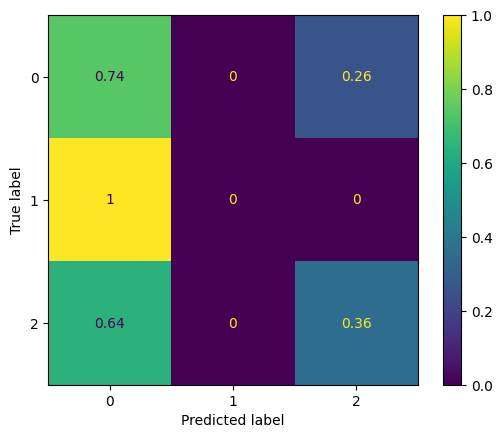



_________________________________




In [ ]:
print("Train pre-trained models from FI-2010 on AAPL data")
evaluate_all(get_models_to_test(True, "all_models"), epochs, train_loader_short, val_loader_short, test_loader_short, train_model=TRAIN_APPL, save_dir=save_loc + "_short(pretrained)")

In [ ]:
# Run a simulation of models on long AAPL data
def evaluate_strategy_with_apple(model: nn.Module, test_loader: data.DataLoader, prices_test: np.ndarray):
    model.to(device)
    model.eval()
    all_preds = []
    with torch.no_grad():
        for inputs, _ in test_loader:
            inputs = inputs.to(device, dtype=torch.float)
            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)
            all_preds.append(preds.cpu().numpy())
    preds = np.concatenate(all_preds)
    return simulate_trading_debug(preds, prices_test)


# Evaluate the DeepLOB Attention model
print("RUNNING ON 1 DAY INTERVAL DATA\n\n")
for model_name, model in get_models_to_test(True, save_loc + "_long").items():
    results = evaluate_strategy_with_apple(model, test_loader_long, prices_long)
    print(f"Results for {model_name}:\n{results}")
    print("\n\n___________________________________\n\n")

print("\n\nRUNNING ON 1 MINUTE INTERVAL DATA\n\n")
for model_name, model in get_models_to_test(True, save_loc + "_short(pretrained)").items():
    results = evaluate_strategy_with_apple(model, test_loader_short, prices_short)
    print(f"Results for {model_name}:\n{results}")
    print("\n\n___________________________________\n\n")


RUNNING ON 1 DAY INTERVAL DATA


Attempting to load from pretrained...
All models loaded successfully


C:\Users\bmanv\AppData\Local\Temp\ipykernel_11012\438007077.py:8: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  models_to_test[model_name].load_state_dict(torch.load(_save_p

Initial cash: 10000, transaction cost: 0.001
BUY at step 0: Bought 83.78 shares at 119.24, Cash: 0.00, Stock: 83.78
SELL at step 44: Sold 83.78 shares at 127.46, Cash: 10667.58
BUY at step 45: Bought 82.16 shares at 129.70, Cash: 0.00, Stock: 82.16
SELL at step 47: Sold 82.16 shares at 123.21, Cash: 10113.14
BUY at step 48: Bought 82.44 shares at 122.55, Cash: -0.00, Stock: 82.44
BUY at step 49: Bought -0.00 shares at 124.50, Cash: -0.00, Stock: 82.44
BUY at step 50: Bought -0.00 shares at 126.10, Cash: 0.00, Stock: 82.44
BUY at step 51: Bought 0.00 shares at 125.39, Cash: 0.00, Stock: 82.44
SELL at step 78: Sold 82.44 shares at 133.14, Cash: 10965.52
BUY at step 79: Bought 82.40 shares at 132.94, Cash: 0.00, Stock: 82.40
SELL at step 82: Sold 82.40 shares at 136.06, Cash: 11200.23
BUY at step 83: Bought 82.30 shares at 135.96, Cash: 0.00, Stock: 82.30
SELL at step 104: Sold 82.30 shares at 145.46, Cash: 11959.43
BUY at step 106: Bought 81.57 shares at 146.47, Cash: 0.00, Stock: 81.57
